<h1>Group Alpha Final Project: <h1>
<h2>Hotel Booking Demand<h2>

*Context*

Hotel adalah sebuah tempat untuk berlibur ataupun tempat untuk tinggal sementara disebuah kota karena adanya perjalanan bisnis atau mengunjungi keluarga. Oleh karena itu, hampir diseluruh kota disetiap negara pasti ada Hotel yang bisa tempati. Bisnis diindustri per-hotelan salah satu bisnis yang cukup menjanjikan, karena demand / permintaannya selalu ada. Tetapi banyak juga hotel yang bangkrut karena demandnya terlalu sedikit atau bahkan tidak ada, karena Hotel tersebut tidak memiliki cukup dana untuk menutupi biaya perawatan hotel, gaji karyawan, biaya operasional Hotel, dll. Demand yang sedikit bisa disebabkan karena jenis hotelnya, fasilitas hotel, pelayanan hotel, dll. Tidak sedikit juga orang yang sudah melakukan reservasi disebuah Hotel tapi akhirnya dibatalkan karena 1 dan lain hal

*Problem Statement*

Bagaimana hotel dapat memprediksi lebih awal apakah sebuah reservasi akan dibatalkan atau tidak, sehingga manajemen dapat:
1. Menetapkan strategi overbooking dan harga yang tepat
2. Melakukan intervensi (reminder, penawaran Non‑Refund, upsell) pada booking berisiko tinggi
3. Mengurangi kerugian pendapatan akibat pembatalan mendadak



*Goal*

Meningkatkan pendapatan bersih (net revenue) melalui:
1. Model prediksi pembatalan pemesanan menggunakan data historis dari 2015-2017
2. Mengetahui faktor apa saja yang memengaruhi customer dalam membatalkan bookingnya

*Pertanyaan untuk data analysis:*
1. Faktor apa (lead time, total nights, special requests, deposit_type, dll) yang paling memengaruhi probabilitas pembatalan?
2. Apakah tingkat pembatalan berbeda signifikan antar Resort Hotel dan City Hotel?
3. Berapa rata‑rata ADR per bulan dan per tahun (2015, 2016, 2017)?
4. Berapa jumlah pembatalan setiap bulan dan setiap tahun?

*Evaluasi Matriks*

Type I (False Positive) – model memprediksi bookingan “akan dibatalkan” padahal booking sebenarnya tidak batal. Pada bisnis hotel, ini dapat menyebabkan over‑booking lebih agresif dari yang semestinya.

Type II (False Negative) – model memprediksi “tidak batal” padahal booking akhirnya batal, berisiko menimbulkan kamar kosong mendadak

Matriks Utama untuk Klasifikasi Pembatalan:
1. Accuracy
2. Precision
3. Recall
4. F1-Score
5. ROC_AUC

<h2> Data Understanding <h2>

In [33]:
# Import library untuk membaca data dan melakukan visualisasi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import shapiro, normaltest, kstest, spearmanr, kruskal
from scipy.stats import(
    shapiro, normaltest, ttest_ind, mannwhitneyu,
    chi2_contingency, pointbiserialr, spearmanr, kruskal, kstest
)

In [34]:
# Membaca dan melihat data CSV

df_hotel_demand_bookings = pd.read_csv('hotel_bookings.csv')
df_hotel_demand_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Deksripsi untuk setiap kolom

* **hotel**: Jenis hotel yang ada di dalam data -> Resort Hotel dan City Hotel

* **is_canceled**: Value yang menandakan apakah bookingnya canceled (1) atau tidak (0)

* **lead_time**: Selisih hari antara tanggal entri pemesanan di PMS dan tanggal kedatangan tamu
* **arrival_date_year**: Tahun kedatangan tamu
* **arrival_date_month**: Bulan kedatangan tamu: “January” sampai “December”
* **arrival_date_week_number**: Nomor minggu ISO (1-53) pada tahun kedatangan
* **arrival_date_day_of_month**: Tanggal kedatangan (1–31)
* **stays_in_weekend_nights**: Malam menginap pada akhir pekan (Sabtu + Minggu)
* **stays_in_week_nights**: Malam menginap pada hari kerja (Senin–Jumat)
* **adults**: Jumlah tamu dewasa dalam pemesanan
* **children**: Jumlah anak (< 18 th) dalam pemesanan. Nilai 0.0 jika tidak ada
* **babies**: Jumlah bayi (< 2 th) dalam pemesanan
* **meal**: Paket makan yang dibeli (contoh: BB = Bed & Breakfast, HB = Half-Board, SC = Self-Catering, Undefined)
* **country**: Negara asal pemesan
* **market_segment**: Penamaan segmentasi market, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **distribution_channel**: Saluran distribusi utama, “TA” -> “Travel Agents” dan “TO” -> “Tour Operators”
* **is_repeated_guest**: (1) jika tamu sudah pernah menginap sebelumnya, (0) jika tamu baru
* **previous_cancellations**: Jumlah pemesanan terdahulu yang pernah dibatalkan oleh tamu sebelum pemesanan saat ini
* **previous_bookings_not_canceled**: Pemesanan terdahulu yang tidak dibatalkan oleh tamu ini
* **reserved_room_type**: Tipe kamar yang diminta saat pemesanan
* **assigned_room_type**: Tipe kamar yang akhirnya diberikan saat check-in, bisa berbeda karena upgrade / overbooking
* **booking_changes**: Berapa kali pemesanan diubah oleh tamu / hotel (tanggal, jumlah tamu, dll.)
* **deposit_type**: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.
* **agent**: Kode agen perjalanan yang memproses pemesanan
* **company**: Kode perusahaan (kontrak corporate) yang memesan
* **days_in_waiting_list**: Jumlah hari dari tamu melakukan reservasi sampai dikonfirmasi
* **customer_type**: Jenis-jenis Tamu
* **adr**: Pendapatan rata-rata per kamar per malam
* **required_car_parking_spaces**: Jumlah slot parkir mobil yang diminta oleh tamu
* **total_of_special_requests**: Jumlah permintaan tambahan dari tamu
* **reservation_status**: Check-Out – Tamu sudah keluar dari Hotel; No-Show – Tamu tidak datang ke Hotel tanpa memberikan alasan (Canceled); Canceled - Tamu melakukan pembatalan reservasi
* **reservation_status_date**: Tanggal saat status di atas dicatat

<h2>Exploratory Data Analysis (EDA) <h2>

In [35]:
# Melihat jumlah baris dan kolom pada dataset

df_hotel_demand_bookings.shape

(119390, 32)

In [36]:
df_hotel_demand_bookings.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [37]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [38]:
# Mengubah tipe data kolom reservation_status_date menjadi datetime

df_hotel_demand_bookings['reservation_status_date'] = pd.to_datetime(df_hotel_demand_bookings['reservation_status_date'])

In [39]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [40]:
df_hotel_demand_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,...,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016-07-30 00:24:47.883407104
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016-02-01 00:00:00
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016-08-07 00:00:00
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017-02-08 00:00:00
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,...,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,NaN


In [41]:
df_hotel_demand_bookings.describe(include='object')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166


In [42]:
for col in df_hotel_demand_bookings.describe(include='object').columns:
    print(f'kolom: {col}')
    print(df_hotel_demand_bookings[col].unique())
    print('-'*50)

kolom: hotel
['Resort Hotel' 'City Hotel']
--------------------------------------------------
kolom: arrival_date_month
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
--------------------------------------------------
kolom: meal
['BB' 'FB' 'HB' 'SC' 'Undefined']
--------------------------------------------------
kolom: country
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM

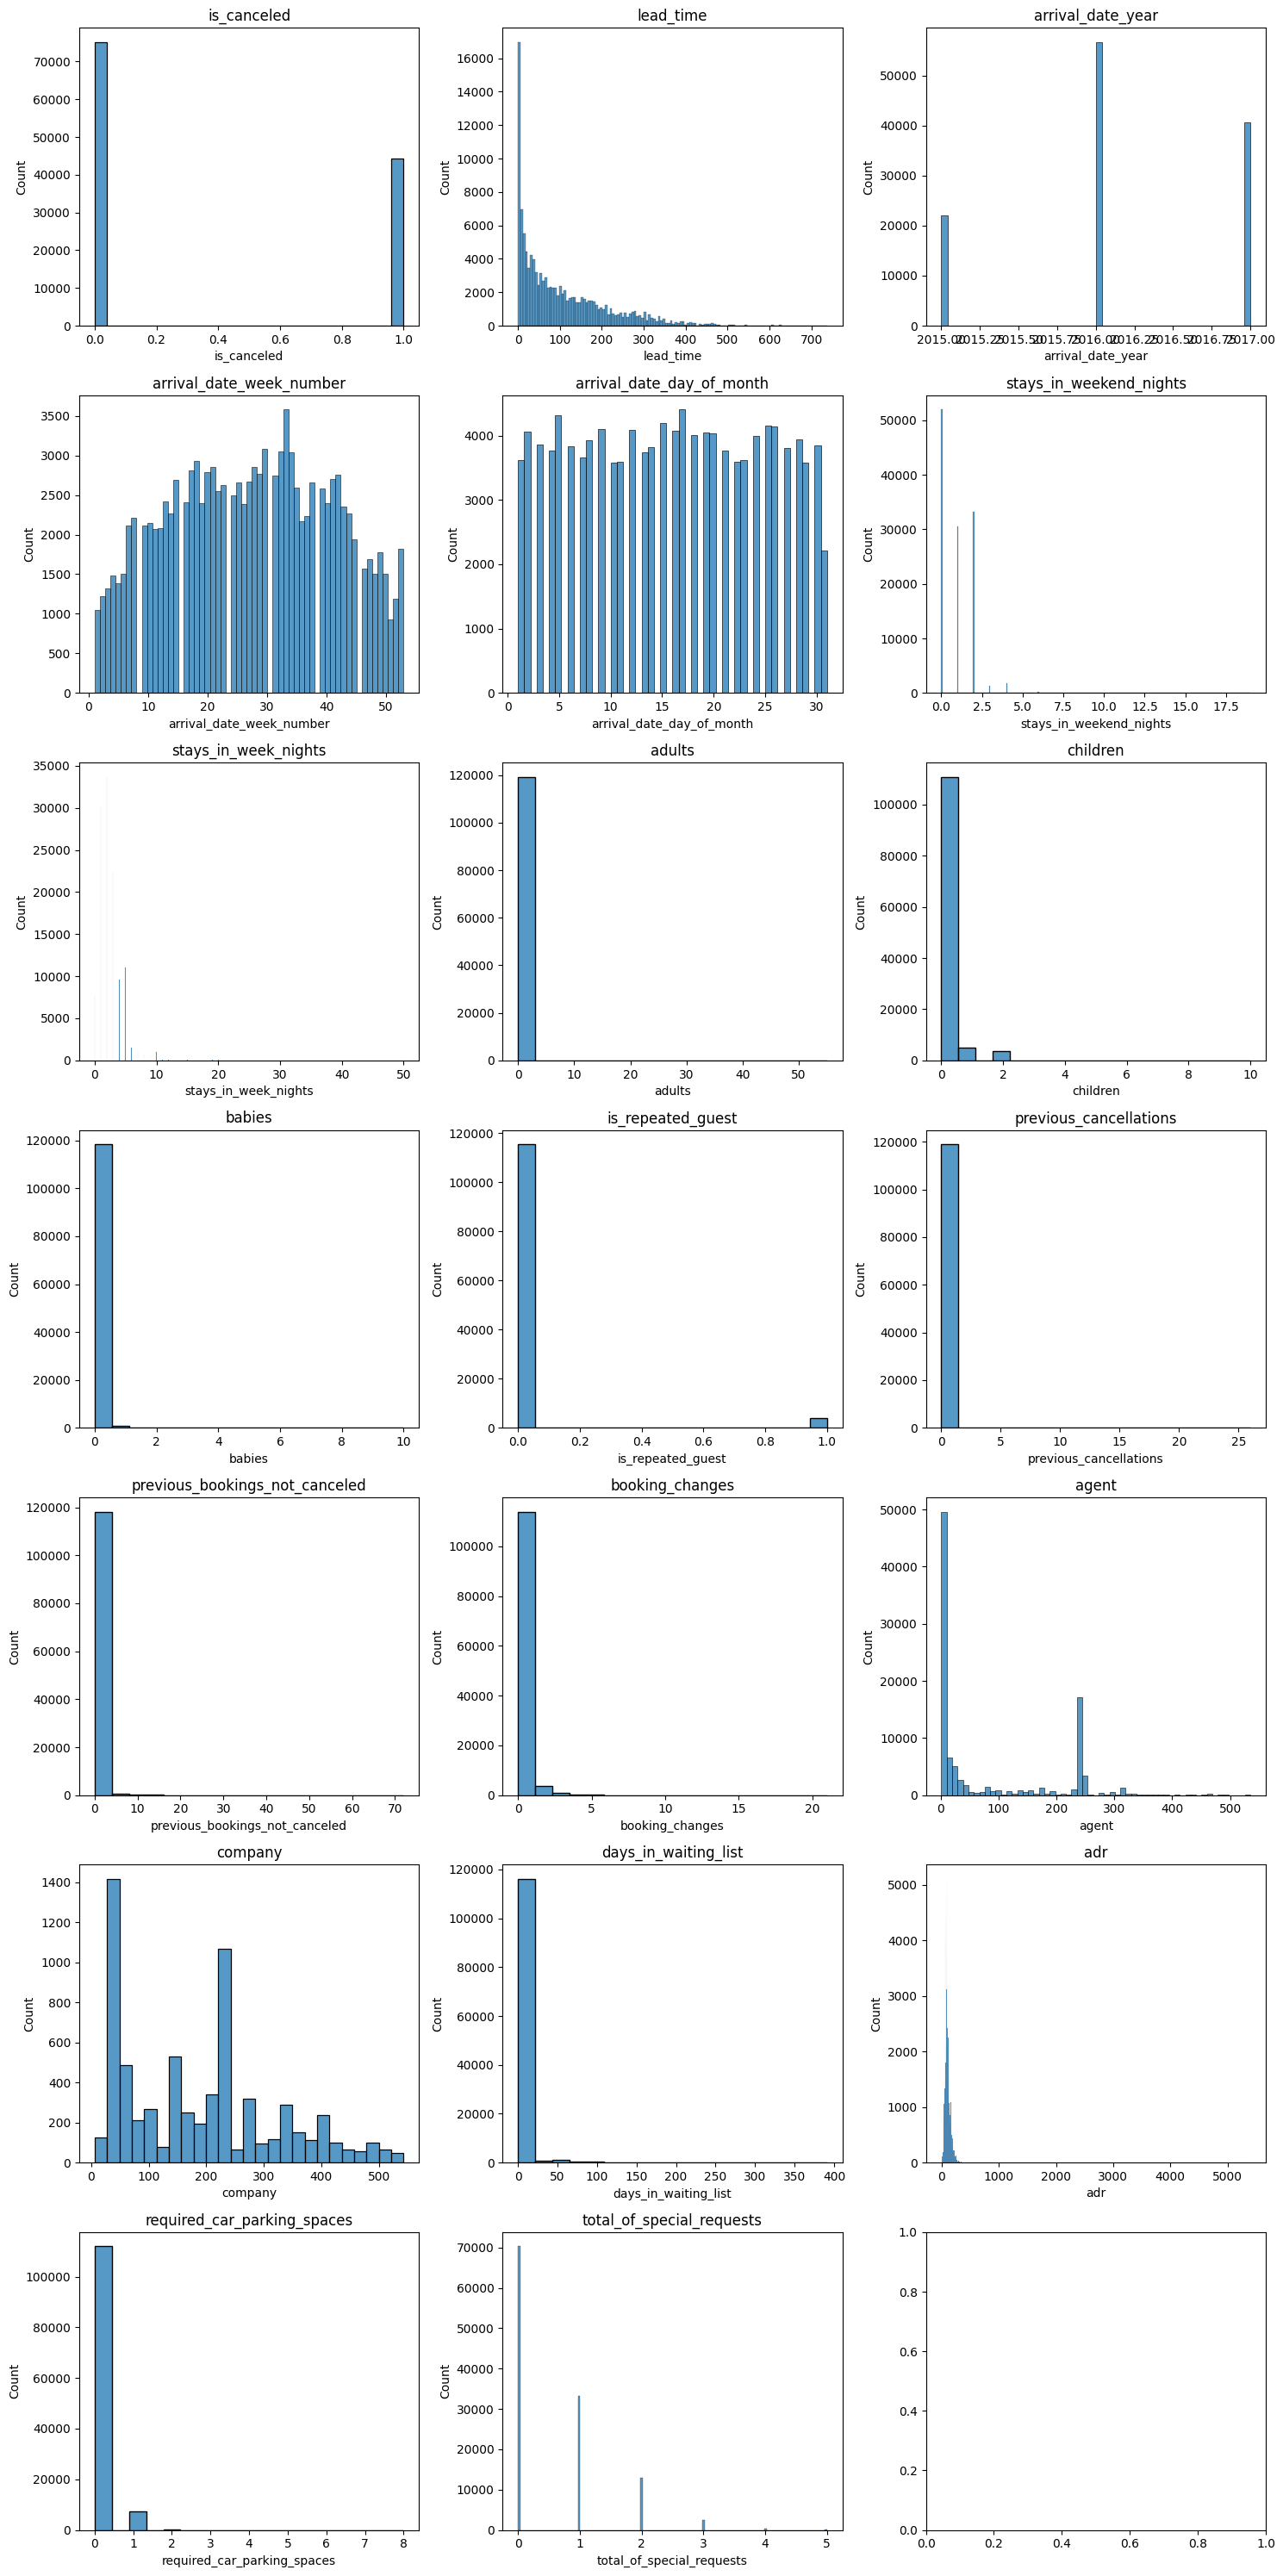

In [43]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.histplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

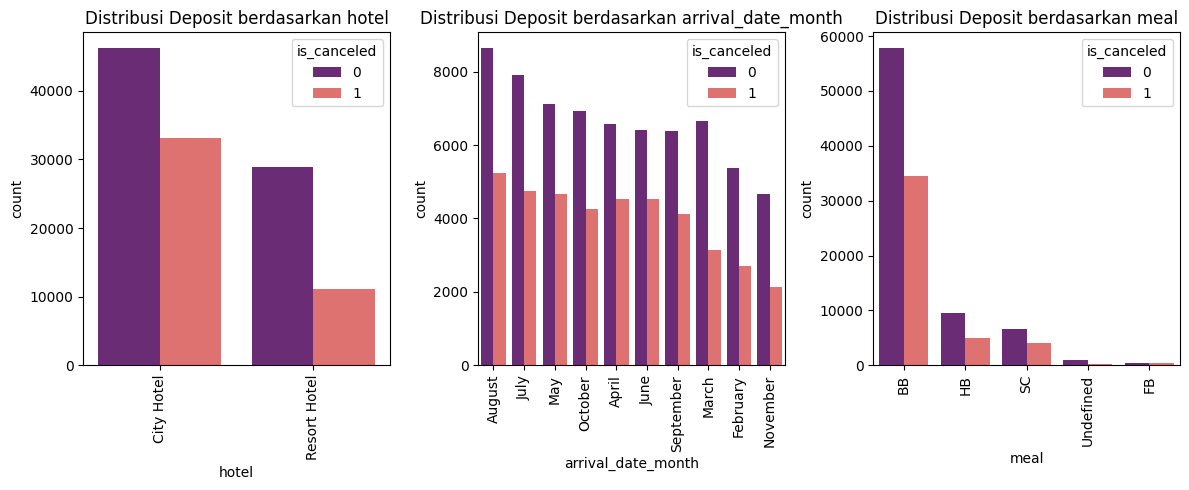

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['hotel', 'arrival_date_month', 'meal']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma',order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

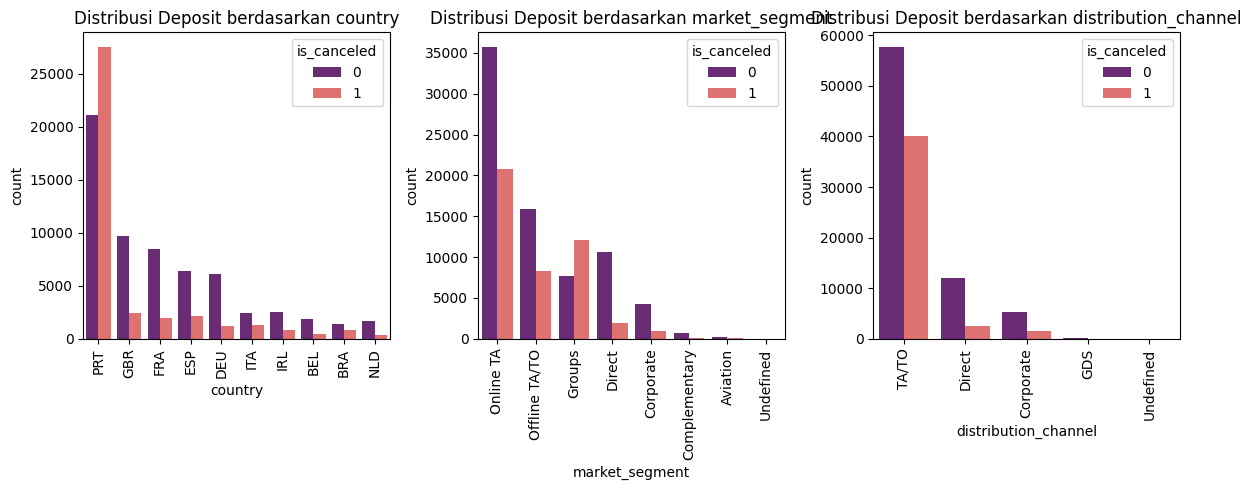

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['country', 'market_segment', 'distribution_channel']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order = df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

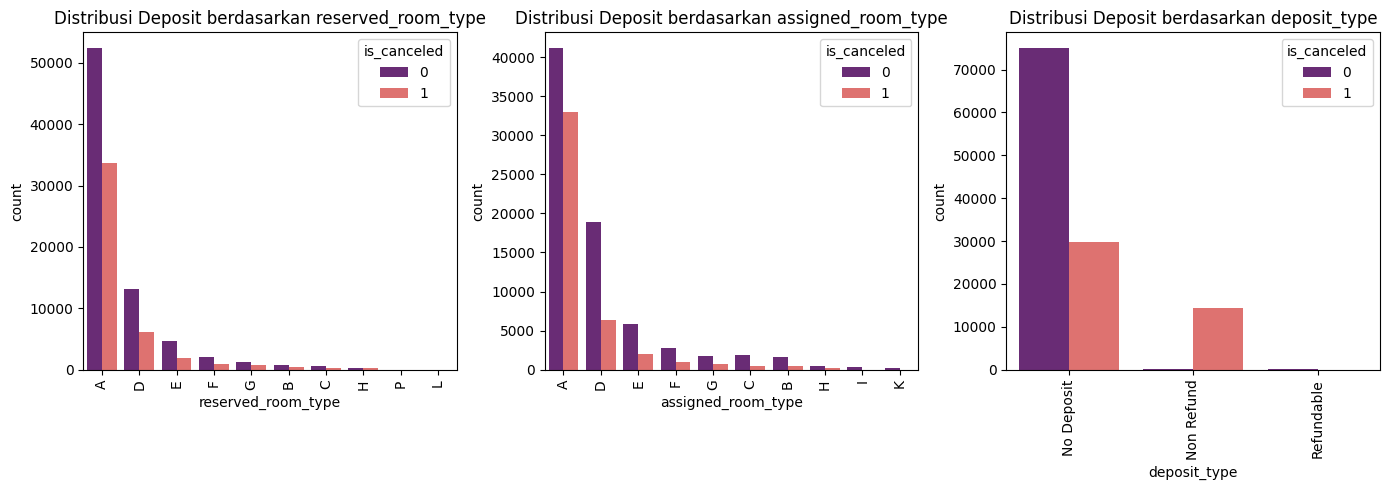

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(14,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['reserved_room_type', 'assigned_room_type', 'deposit_type']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

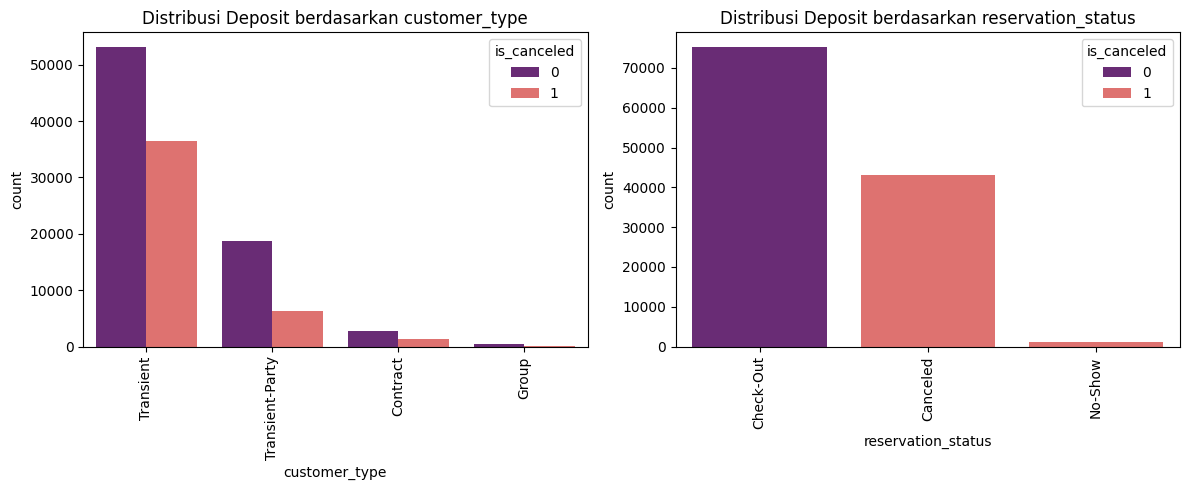

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

for i, feature in enumerate(df_hotel_demand_bookings[['customer_type', 'reservation_status']].columns.tolist()):
    sns.countplot(x=df_hotel_demand_bookings[feature], hue=df_hotel_demand_bookings['is_canceled'], palette='magma', order=df_hotel_demand_bookings[feature].value_counts().iloc[:10].index, ax=axes[i])
    axes[i].set_title(f'Distribusi Deposit berdasarkan {feature}')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [48]:
# Melakukan uji korelasi untuk mengetahui hubungan antar kolom numerik

num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])

corr_matrix = num_cols.corr(method='pearson')
corr_matrix

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000000,0.293123,0.016660,0.008148,-0.006130,-0.001791,0.024765,0.060017,0.005048,-0.032491,-0.084793,0.110133,-0.057358,-0.144381,-0.083114,-0.020642,0.054186,0.047557,-0.195498,-0.234658
lead_time,0.293123,1.000000,0.040142,0.126871,0.002268,0.085671,0.165799,0.119519,-0.037622,-0.020915,-0.124410,0.086042,-0.073548,0.000149,-0.069741,0.151464,0.170084,-0.063077,-0.116451,-0.095712
arrival_date_year,0.016660,0.040142,1.000000,-0.540561,-0.000221,0.021497,0.030883,0.029635,0.054624,-0.013192,0.010341,-0.119822,0.029218,0.030872,0.063457,0.259095,-0.056497,0.197580,-0.013684,0.108531
arrival_date_week_number,0.008148,0.126871,-0.540561,1.000000,0.066809,0.018208,0.015558,0.025909,0.005518,0.010395,-0.030131,0.035501,-0.020904,0.005508,-0.031201,-0.076760,0.022933,0.075791,0.001920,0.026149
arrival_date_day_of_month,-0.006130,0.002268,-0.000221,0.066809,1.000000,-0.016354,-0.028174,-0.001566,0.014544,-0.000230,-0.006145,-0.027011,-0.000300,0.010613,0.001487,0.044858,0.022728,0.030245,0.008683,0.003062
stays_in_weekend_nights,-0.001791,0.085671,0.021497,0.018208,-0.016354,1.000000,0.498969,0.091871,0.045793,0.018483,-0.087239,-0.012775,-0.042715,0.063281,0.140739,0.066749,-0.054151,0.049342,-0.018554,0.072671
stays_in_week_nights,0.024765,0.165799,0.030883,0.015558,-0.028174,0.498969,1.000000,0.092976,0.044203,0.020191,-0.097245,-0.013992,-0.048743,0.096209,0.182382,0.182211,-0.002020,0.065237,-0.024859,0.068192
adults,0.060017,0.119519,0.029635,0.025909,-0.001566,0.091871,0.092976,1.000000,0.030447,0.018146,-0.146426,-0.006738,-0.107983,-0.051673,-0.035594,0.207793,-0.008283,0.230641,0.014785,0.122884
children,0.005048,-0.037622,0.054624,0.005518,0.014544,0.045793,0.044203,0.030447,1.000000,0.024030,-0.032859,-0.024730,-0.021072,0.048949,0.041066,0.030931,-0.033273,0.324854,0.056253,0.081745
babies,-0.032491,-0.020915,-0.013192,0.010395,-0.000230,0.018483,0.020191,0.018146,0.024030,1.000000,-0.008943,-0.007501,-0.006550,0.083440,0.036184,0.019206,-0.010621,0.029186,0.037383,0.097889


<h2>Data Pre - Processing<h2>

Data Duplikasi

In [49]:
# Check for duplicated rows
print('Number of duplicated rows = ', df_hotel_demand_bookings.duplicated().sum())

Number of duplicated rows =  31994


In [50]:
df_hotel_demand_bookings.drop_duplicates(inplace=True)

In [51]:
len(df_hotel_demand_bookings)

87396

Menangani Missing Value

In [52]:
# Display unique items from each column
def display_unique(df):
  listUniqueItem = []
  for col in df.columns :
      listUniqueItem.append( [col, df[col].nunique(), df[col].isna().sum(), df[col].unique()])

  tableDesc = pd.DataFrame(columns=['Column Name', 'Total of Unique', 'null', 'Unique Sample'],
                      data=listUniqueItem)
  return tableDesc
display_unique(df_hotel_demand_bookings)

,Column Name,Total of Unique,null,Unique Sample
0,hotel,2,0,"[Resort Hotel, City Hotel]"
1,is_canceled,2,0,"[0, 1]"
2,lead_time,479,0,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68..."
3,arrival_date_year,3,0,"[2015, 2016, 2017]"
4,arrival_date_month,12,0,"[July, August, September, October, November, D..."
5,arrival_date_week_number,53,0,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3..."
6,arrival_date_day_of_month,31,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,stays_in_weekend_nights,17,0,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,..."
8,stays_in_week_nights,35,0,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,..."
9,adults,14,0,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]"


In [53]:
# Check null values
df_null = pd.DataFrame({'Null Values' : df_hotel_demand_bookings.isnull().sum(),
                        'Percentage Null Values' :
                         (df_hotel_demand_bookings.isna().sum()) / (df_hotel_demand_bookings.shape[0]) * (100)})
df_null = df_null[df_null['Null Values']>0]
df_null.sort_values('Percentage Null Values', ascending=False)

,Null Values,Percentage Null Values
company,82137,93.982562
agent,12193,13.951439
country,452,0.517186
children,4,0.004577


In [54]:
# Menghapus kolom yang tidak diperlukan dalam analisis
# Mengahpus kolom yang memiliki value NaN
# Kolom Company & Agent -> Tidak Relevant untuk analisis, karena tanpa kolom company analisis tetap bisa dilakukan dan juga kolom yang paling banyak missing value

df_hotel_demand_bookings.drop(['company', 'agent'], axis=1, inplace=True)

In [55]:
df_hotel_demand_bookings = df_hotel_demand_bookings.fillna({'country': 'unknown', 'children': 0.0})

In [56]:
# Melihat kembali apakah masih ada data yang hilang

df_hotel_demand_bookings.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

ANOMALI DATA

In [57]:
df_hotel_demand_bookings[
    (df_hotel_demand_bookings['adults'] == 0) &
    (df_hotel_demand_bookings['children'] == 0) &
    (df_hotel_demand_bookings['babies'] == 0)
].head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,...,I,1,No Deposit,0,Transient-Party,0.0,0,0,Check-Out,2015-10-06
2409,Resort Hotel,0,0,2015,October,42,12,0,0,0,...,I,0,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-10-12
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,...,C,0,No Deposit,0,Transient-Party,0.0,0,0,Check-Out,2015-11-23
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,...,A,1,No Deposit,122,Transient-Party,0.0,0,0,Check-Out,2016-01-04
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,...,C,1,No Deposit,122,Transient-Party,0.0,0,0,Check-Out,2016-01-05


In [58]:
df_hotel_demand_bookings = df_hotel_demand_bookings[
    ~(
        (df_hotel_demand_bookings['adults'] == 0) &
        (df_hotel_demand_bookings['children'] == 0) &
        (df_hotel_demand_bookings['babies'] == 0)
    )
]

len(df_hotel_demand_bookings)

87230

In [59]:
# Menghapus baris yang memiliki nilai 0 pada kolom adults
# Karena tidak mungkin ada pemesanan hotel tanpa orang dewasa

df_hotel_demand_bookings = df_hotel_demand_bookings[df_hotel_demand_bookings['adults'] != 0]

In [60]:
df_hotel_demand_bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,0,Transient,104.40,0,0,Check-Out,2017-09-07


Data Outlier

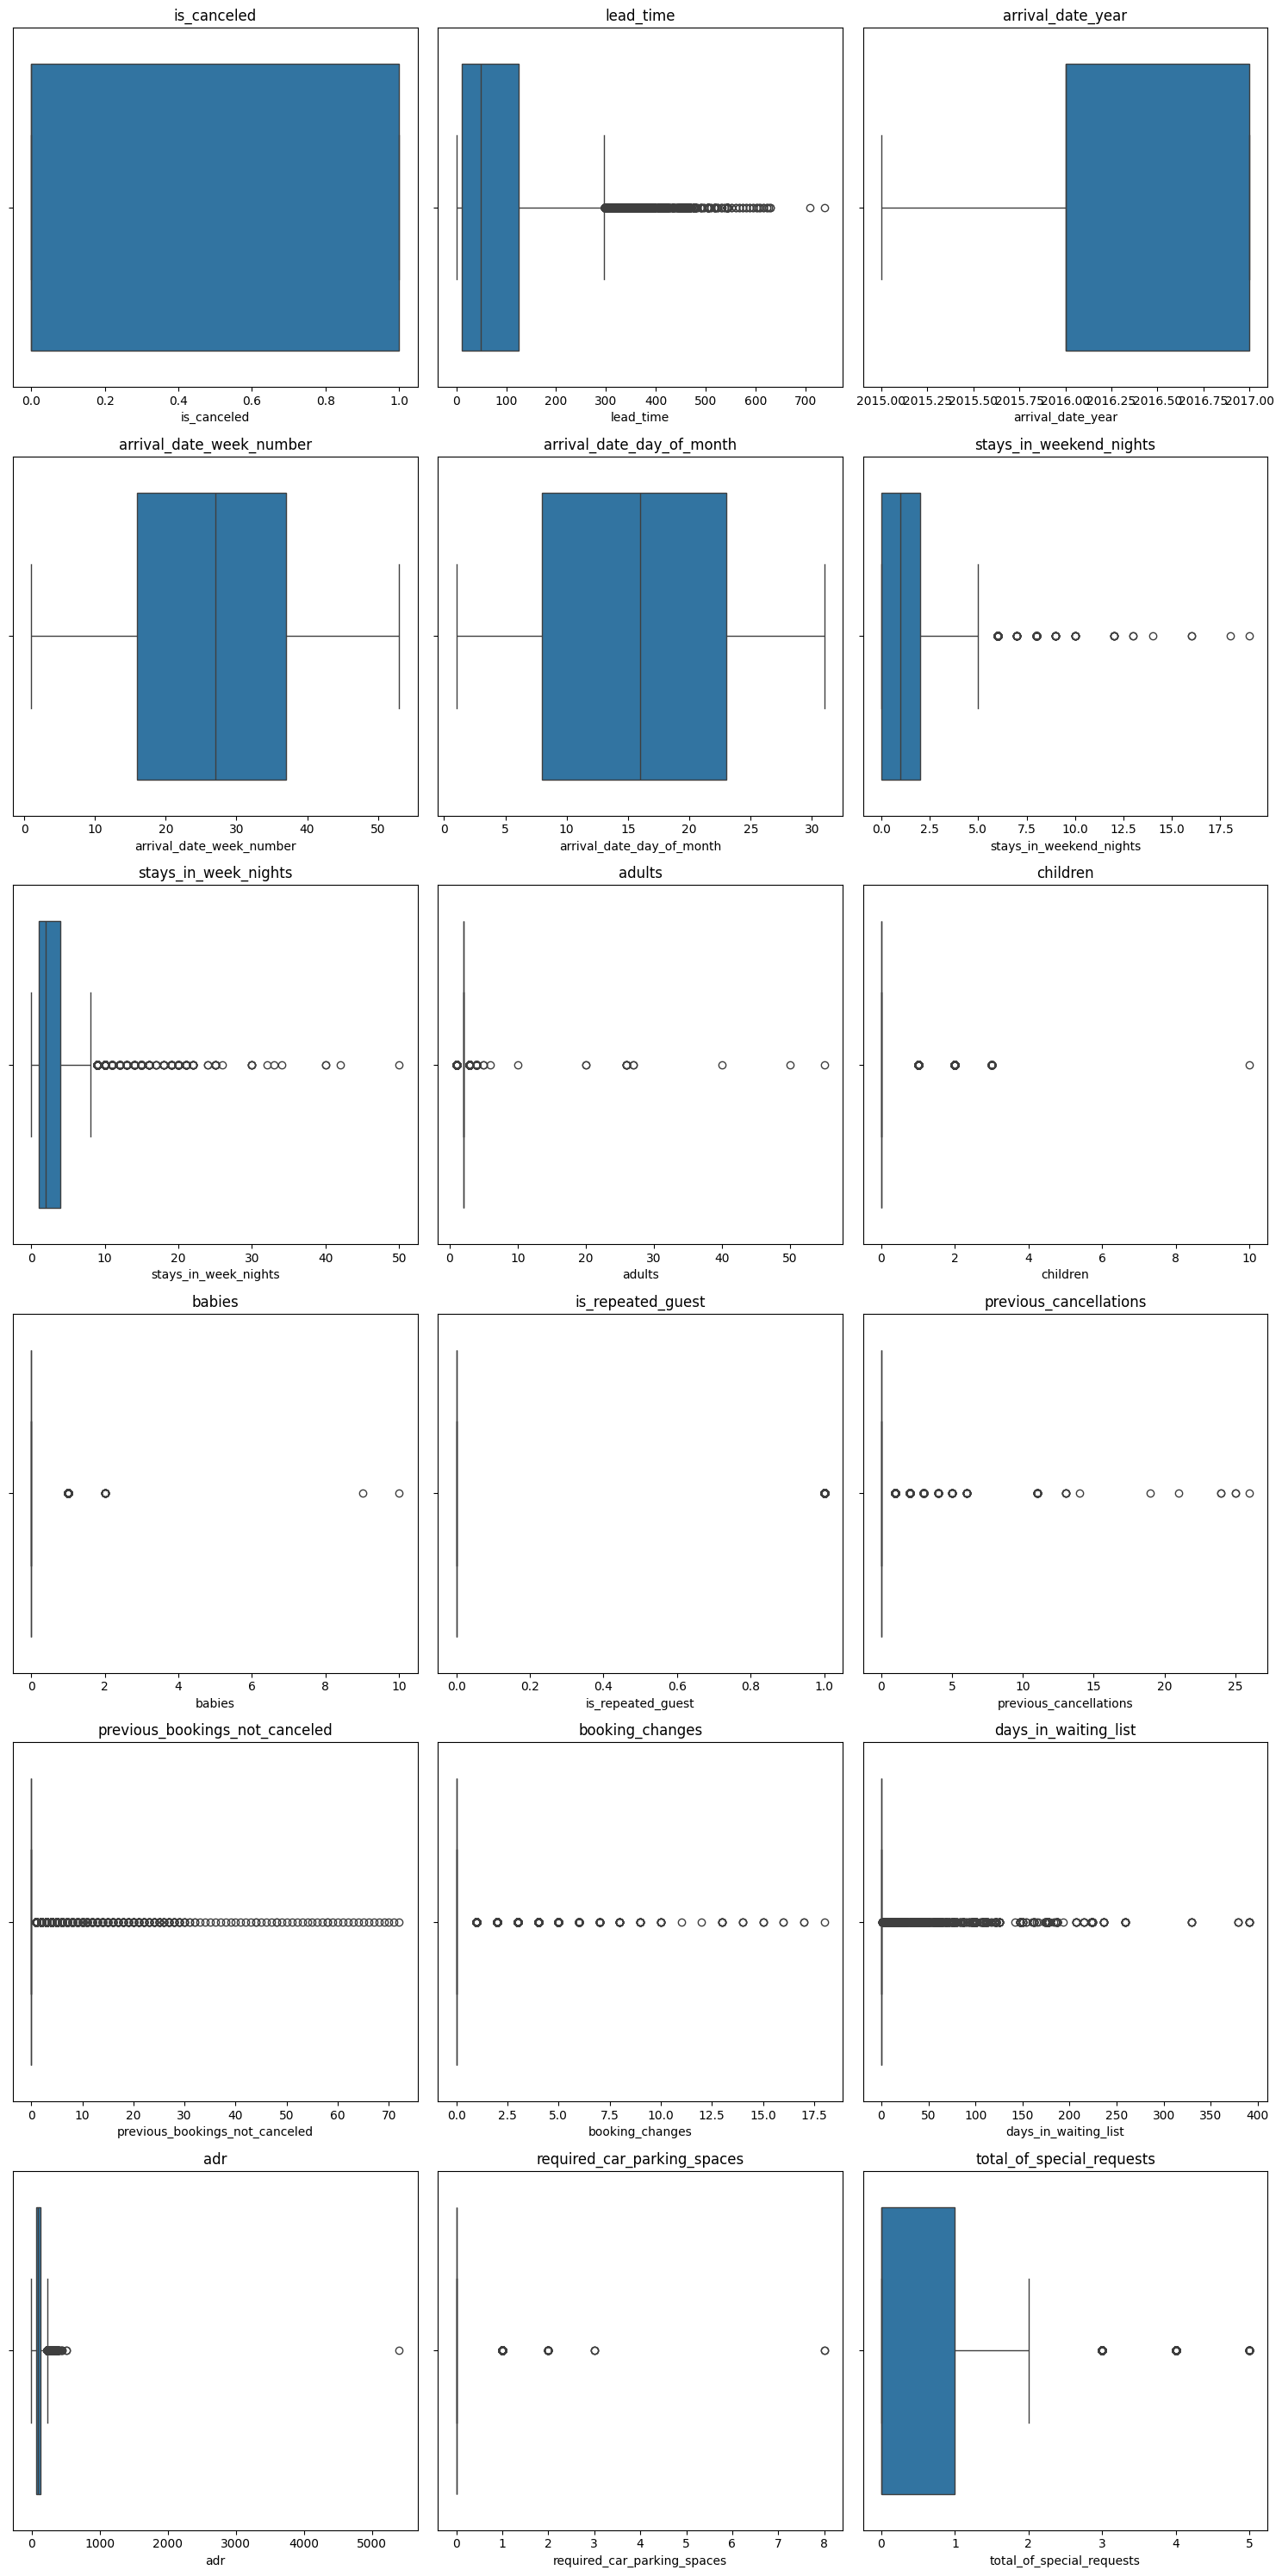

In [61]:
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))

for i, feature in enumerate(num_cols):
    row, col = divmod(i, 3)  
    sns.boxplot(x=df_hotel_demand_bookings[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

In [62]:
from scipy.stats import median_abs_deviation

df_cleaned = df_hotel_demand_bookings.copy()
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

data_outlier = []
mask = pd.Series([True] * len(df_cleaned), index=df_cleaned.index)

for col in numeric_cols:
    col_values = df_cleaned[col].values
    median = np.median(col_values)
    mad = median_abs_deviation(col_values)
    if mad == 0:
        continue  # Skip constant column
    modified_z = 0.6745 * (col_values - median) / mad
    col_mask = np.abs(modified_z) < 3.5
    num_outliers = (~col_mask).sum()

    mask = mask & col_mask

    data_outlier.append([col, median, mad, num_outliers])

df_hotel_demand_bookings = df_cleaned[mask]

df_outlier = pd.DataFrame(
    data_outlier,
    columns=['Nama Kolom', 'Median', 'MAD', 'Jumlah Outliers']
).sort_values('Jumlah Outliers', ascending=False).reset_index(drop=True)

print("Data setelah menghapus outlier:", df_hotel_demand_bookings.shape)
df_outlier

Data setelah menghapus outlier: (80920, 30)


,Nama Kolom,Median,MAD,Jumlah Outliers
0,lead_time,49.00,44.00,3194
1,stays_in_week_nights,2.00,1.00,2122
2,adr,98.33,30.37,1059
3,stays_in_weekend_nights,1.00,1.00,101
4,arrival_date_year,2016.00,1.00,0
5,arrival_date_week_number,27.00,11.00,0
6,arrival_date_day_of_month,16.00,8.00,0


In [63]:
df_hotel_demand_bookings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80920 entries, 2 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           80920 non-null  object        
 1   is_canceled                     80920 non-null  int64         
 2   lead_time                       80920 non-null  int64         
 3   arrival_date_year               80920 non-null  int64         
 4   arrival_date_month              80920 non-null  object        
 5   arrival_date_week_number        80920 non-null  int64         
 6   arrival_date_day_of_month       80920 non-null  int64         
 7   stays_in_weekend_nights         80920 non-null  int64         
 8   stays_in_week_nights            80920 non-null  int64         
 9   adults                          80920 non-null  int64         
 10  children                        80920 non-null  float64       
 11  babies

In [64]:
len(df_hotel_demand_bookings)

80920

<h2>Data Analysis<h2>

Uji Distribusi Normal dengan Uji Frequentist

In [65]:
# Memilih hanya kolom numerik
num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number]).columns

# Fungsi untuk Kolmogorov Smirnov Test untuk setiap kolom numerik
def ks_test(series):
    data = series.dropna()
    mu, sigma = data.mean(), data.std(ddof=0)
    # K‑S terhadap N(mu, sigma)
    stat, p = kstest(data, "norm", args=(mu, sigma))
    return stat, p

# Fungsi untuk D'Agostino and Pearson Test untuk setiap kolom numerik

def dagostino_pearson(series):
    data = series.dropna()
    # scipy normaltest (omnibus) ⇒ p kecil → tolak normalitas
    stat, p = normaltest(data)
    return stat, p

rows = []
for col in num_cols:
    ks_stat,  ks_p  = ks_test(df_hotel_demand_bookings[col])
    dp_stat, dp_p   = dagostino_pearson(df_hotel_demand_bookings[col])
    rows.append({
        "column": col,
        "KS_stat": ks_stat,        "KS_pvalue": ks_p,
        "DP_stat": dp_stat,        "DP_pvalue": dp_p,
        "n": df_hotel_demand_bookings[col].notna().sum()
    })

result = pd.DataFrame(rows).set_index("column")
result = result.sort_values("KS_pvalue", ascending=True)

pd.set_option("display.float_format", "{:.3e}".format)
print("Normality tests (Kolmogorov–Smirnov & D'Agostino‑Pearson):")
display(result)

Normality tests (Kolmogorov–Smirnov & D'Agostino‑Pearson):


,KS_stat,KS_pvalue,DP_stat,DP_pvalue,n
column,,,,,
is_canceled,4.606e-01,0.000e+00,2.025e+04,0.000e+00,80920
days_in_waiting_list,5.207e-01,0.000e+00,1.678e+05,0.000e+00,80920
booking_changes,4.717e-01,0.000e+00,8.034e+04,0.000e+00,80920
previous_bookings_not_canceled,5.011e-01,0.000e+00,1.761e+05,0.000e+00,80920
previous_cancellations,5.134e-01,0.000e+00,2.203e+05,0.000e+00,80920
is_repeated_guest,5.409e-01,0.000e+00,7.320e+04,0.000e+00,80920
babies,5.273e-01,0.000e+00,1.860e+05,0.000e+00,80920
required_car_parking_spaces,5.336e-01,0.000e+00,6.222e+04,0.000e+00,80920
children,5.266e-01,0.000e+00,5.859e+04,0.000e+00,80920


Dari hasil test uji distribusi normal menggunakan Kolmogrov Smirnov dan D'Agostino and Pearson, kita bisa melihat pada kolom KS_pvalue dan DP_pvalue untuk setiap kolom numerik, p-value <= 0.05 yang artinya datanya tidak terdistribusi normal

Tetapi, karena dataset yang kita miliki sangat banyak, kita bisa asumsikan data kita terdisitribusi normal

Menentukan Kolum Numerik dan Kategorikal

In [66]:
num_cols_names = [
    'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'is_repeated_guest',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests'
]

df_num = df_hotel_demand_bookings[num_cols_names + ['is_canceled']]

cat_cols_names = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type',
    'deposit_type', 'customer_type'
]

df_cat = df_hotel_demand_bookings[cat_cols_names + ['is_canceled']]

In [67]:
print(type(col),col)

<class 'str'> total_of_special_requests


Uji Normalitas Data Numerik Menggunakan D'Agostino Test

In [68]:
normality_results = []

for col in num_cols_names:
    data = df_num[col].sample(5000, random_state=42) if df_num.shape[0] > 5000 else df_num[col]
    stat, pval = normaltest(data)
    normal = pval > 0.05
    normality_results.append((col, pval, normal))
    print(f"{col:<35} | p-value: {pval:.4f} | Normal: {'Yes' if normal else 'No'}")

lead_time                           | p-value: 0.0000 | Normal: No
stays_in_weekend_nights             | p-value: 0.0000 | Normal: No
stays_in_week_nights                | p-value: 0.0000 | Normal: No
adults                              | p-value: 0.0000 | Normal: No
children                            | p-value: 0.0000 | Normal: No
babies                              | p-value: 0.0000 | Normal: No
is_repeated_guest                   | p-value: 0.0000 | Normal: No
previous_cancellations              | p-value: 0.0000 | Normal: No
previous_bookings_not_canceled      | p-value: 0.0000 | Normal: No
booking_changes                     | p-value: 0.0000 | Normal: No
days_in_waiting_list                | p-value: 0.0000 | Normal: No
adr                                 | p-value: 0.0000 | Normal: No
required_car_parking_spaces         | p-value: 0.0000 | Normal: No
total_of_special_requests           | p-value: 0.0000 | Normal: No


Uji Statistik Numerik

In [69]:
print("\nUji Statistik Numerik berdasarkan Normalitas:\n")

for col, _, is_normal in normality_results:
    data_0 = df_num[df_num['is_canceled'] == 0][col]
    data_1 = df_num[df_num['is_canceled'] == 1][col]

    if is_normal:
        stat, pval = ttest_ind(data_0, data_1, equal_var=False)
        test_name = 'T-Test'
    else:
        stat, pval = mannwhitneyu(data_0, data_1, alternative='two-sided')
        test_name = 'Mann-Whitney U'

    mean_0 = data_0.mean()
    mean_1 = data_1.mean()

    print(f"{col:<35} | Test: {test_name:<15} | p-value: {pval:.4f} | Mean[0]: {mean_0:.2f} | Mean[1]: {mean_1:.2f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")



Uji Statistik Numerik berdasarkan Normalitas:

lead_time                           | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 61.18 | Mean[1]: 90.46 | Signifikan: Yes
stays_in_weekend_nights             | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.89 | Mean[1]: 1.01 | Signifikan: Yes
stays_in_week_nights                | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 2.31 | Mean[1]: 2.63 | Signifikan: Yes
adults                              | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 1.85 | Mean[1]: 1.95 | Signifikan: Yes
children                            | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.11 | Mean[1]: 0.16 | Signifikan: Yes
babies                              | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.01 | Mean[1]: 0.01 | Signifikan: Yes
is_repeated_guest                   | Test: Mann-Whitney U  | p-value: 0.0000 | Mean[0]: 0.05 | Mean[1]: 0.01 | Signifikan: Yes
previous_cancellations              | Test: Mann-Whitn

Uji Statistik Kategorikal

In [70]:
for col in cat_cols_names:
    table = pd.crosstab(df_cat[col], df_cat['is_canceled'])
    if table.shape[0] < 2 or table.shape[1] != 2:
        continue
    chi2, pval, dof, expected = chi2_contingency(table)
    print(f"{col:<25} | p-value: {pval:.4f} | Signifikan: {'Yes' if pval < 0.05 else 'No'}")

hotel                     | p-value: 0.0000 | Signifikan: Yes
arrival_date_month        | p-value: 0.0000 | Signifikan: Yes
meal                      | p-value: 0.0000 | Signifikan: Yes
market_segment            | p-value: 0.0000 | Signifikan: Yes
distribution_channel      | p-value: 0.0000 | Signifikan: Yes
reserved_room_type        | p-value: 0.0000 | Signifikan: Yes
assigned_room_type        | p-value: 0.0000 | Signifikan: Yes
deposit_type              | p-value: 0.0000 | Signifikan: Yes
customer_type             | p-value: 0.0000 | Signifikan: Yes


In [71]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))    
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = ['hotel', 'arrival_date_month', 'meal', 'market_segment', 
            'distribution_channel', 'reserved_room_type', 
            'assigned_room_type', 'deposit_type', 'customer_type']

for col in cat_cols:
    confusion_mat = pd.crosstab(df_hotel_demand_bookings[col], df_hotel_demand_bookings['is_canceled'])
    print(f"Cramér's V for {col}: {cramers_v(confusion_mat):.4f}")

Cramér's V for hotel: 0.0704
Cramér's V for arrival_date_month: 0.0828
Cramér's V for meal: 0.0678
Cramér's V for market_segment: 0.2187
Cramér's V for distribution_channel: 0.1497
Cramér's V for reserved_room_type: 0.0521
Cramér's V for assigned_room_type: 0.0870
Cramér's V for deposit_type: 0.1396
Cramér's V for customer_type: 0.1233


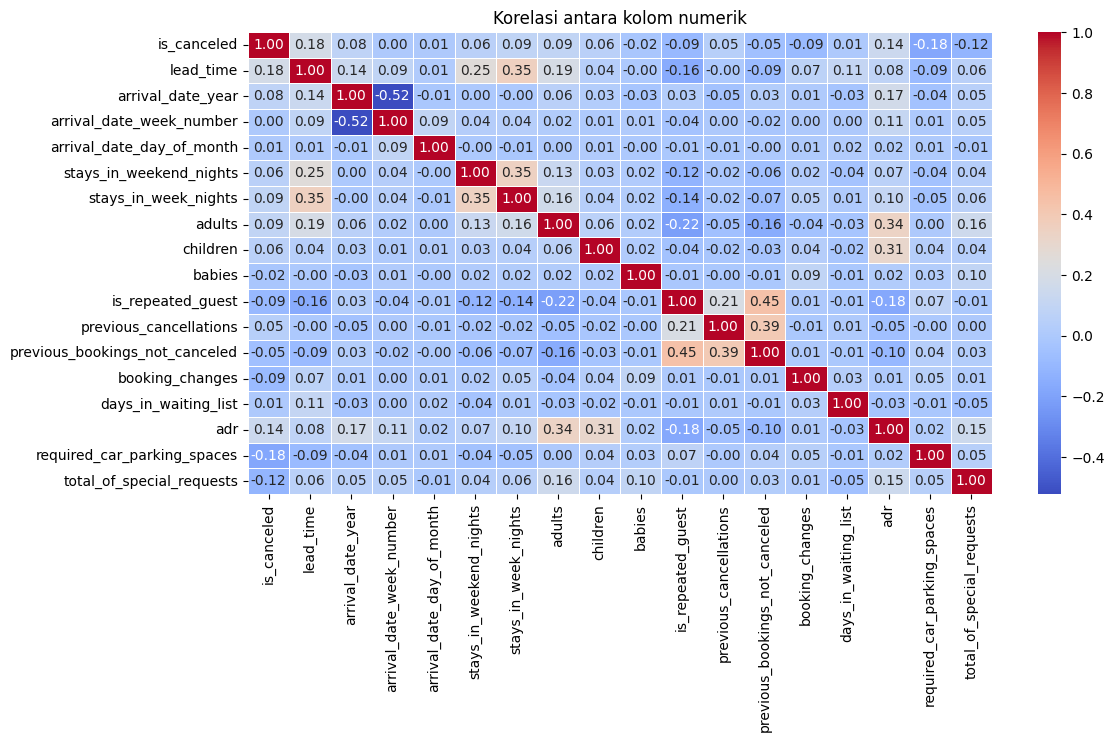

In [72]:
# Melihat korelasi antar kolom numerik

num_cols = df_hotel_demand_bookings.select_dtypes(include=[np.number])
correlation_matrix = num_cols.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasi antara kolom numerik")
plt.show()

In [73]:
# Melihat pasangan kolom yang memiliki korelasi (positif maupun negatif) tertinggi

corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
         .stack()
         .reset_index()
         .rename(columns={"level_0":"Variable 1","level_1":"Variable 2",0:"r value"})
         .sort_values("r value", ascending=False)
)


print("\nPasangan kolom dengan korelasi tertinggi:")

df_corr_pairs = pd.DataFrame(corr_pairs)
display(df_corr_pairs)



Pasangan kolom dengan korelasi tertinggi:


,Variable 1,Variable 2,r value
126,is_repeated_guest,previous_bookings_not_canceled,4.466e-01
132,previous_cancellations,previous_bookings_not_canceled,3.948e-01
21,lead_time,stays_in_week_nights,3.536e-01
75,stays_in_weekend_nights,stays_in_week_nights,3.494e-01
105,adults,adr,3.353e-01
...,...,...,...
25,lead_time,is_repeated_guest,-1.619e-01
129,is_repeated_guest,adr,-1.761e-01
15,is_canceled,required_car_parking_spaces,-1.814e-01
100,adults,is_repeated_guest,-2.164e-01


In [74]:
# Melihat korelasi antara kolom is_canceled dengan kolom numerik lainnya
# Diurutkan dari yang paling besar korelasinya

target = "is_canceled"
corr_to_target = (
    correlation_matrix[target]
    .drop(target)
    .sort_values(ascending=False)
)

print("\nKorelasi kolom lain terhadap:", target)
display(corr_to_target)


Korelasi kolom lain terhadap: is_canceled


lead_time                         1.849e-01
adr                               1.406e-01
adults                            9.454e-02
stays_in_week_nights              8.931e-02
arrival_date_year                 8.319e-02
children                          5.794e-02
stays_in_weekend_nights           5.608e-02
previous_cancellations            4.502e-02
days_in_waiting_list              7.044e-03
arrival_date_day_of_month         6.887e-03
arrival_date_week_number          1.813e-03
babies                           -1.976e-02
previous_bookings_not_canceled   -5.253e-02
booking_changes                  -8.553e-02
is_repeated_guest                -8.952e-02
total_of_special_requests        -1.173e-01
required_car_parking_spaces      -1.814e-01
Name: is_canceled, dtype: float64

TARGET FEATURE DISTRIBUTION

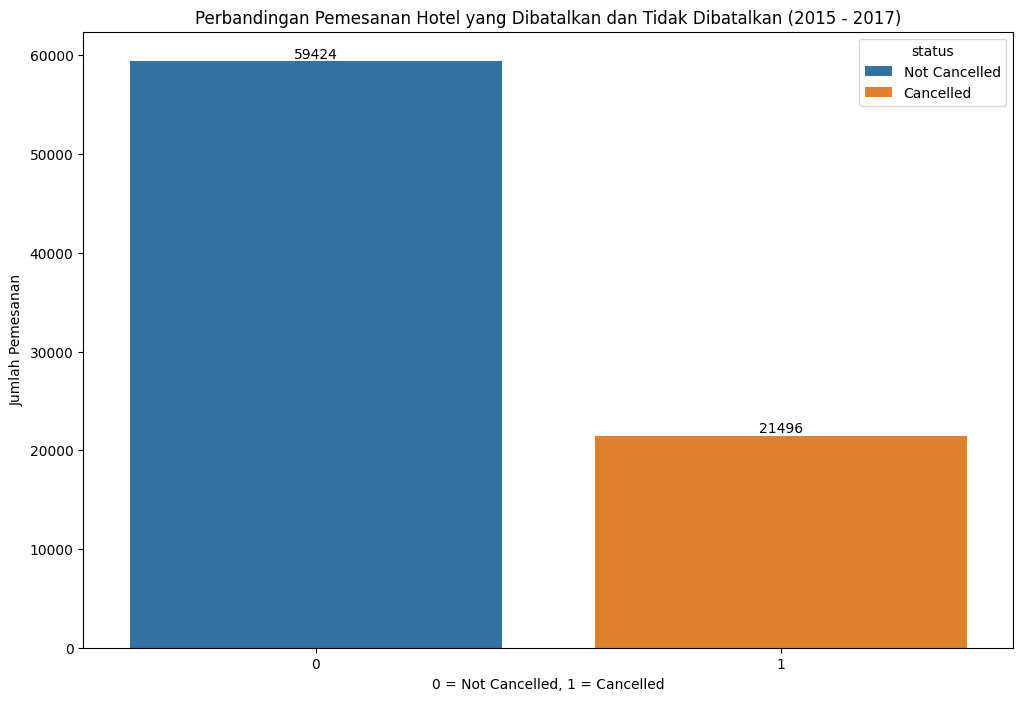

In [75]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan

plt.figure(figsize=(12,8))

counts = (
    df_hotel_demand_bookings.groupby(['is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Cancelled', 1: 'Cancelled'})

cancelation_rate_barplot = sns.barplot(
    data=counts,
    x='is_canceled',
    y='count',
    hue='status'
)

for container in cancelation_rate_barplot.containers:
    cancelation_rate_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan (2015 - 2017)')
plt.xlabel('0 = Not Cancelled, 1 = Cancelled')
plt.ylabel('Jumlah Pemesanan')
plt.show()

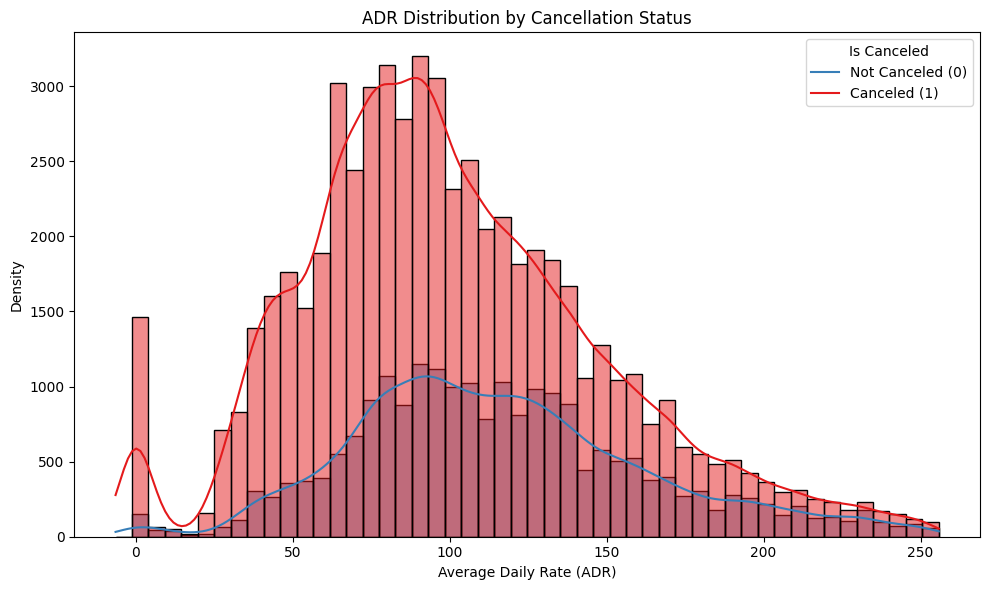

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your DataFrame (e.g., df) contains 'adr' and 'is_canceled'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='adr', hue='is_canceled', bins=50, kde=True, palette='Set1')

plt.title('ADR Distribution by Cancellation Status')
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Density')
plt.legend(title='Is Canceled', labels=['Not Canceled (0)', 'Canceled (1)'])
plt.tight_layout()
plt.show()


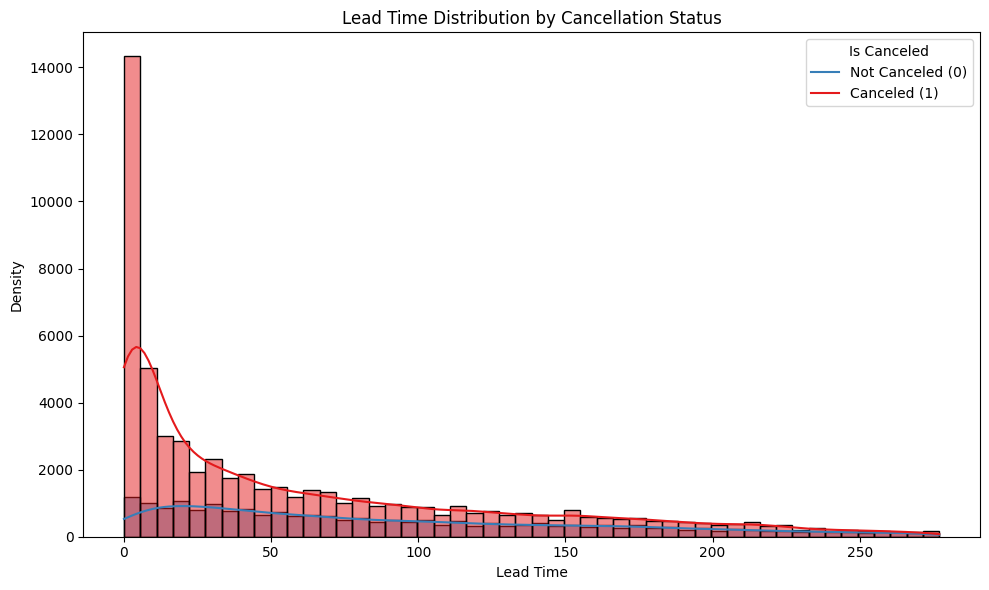

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=df_hotel_demand_bookings, x='lead_time', hue='is_canceled', bins=50, kde=True, palette='Set1')

plt.title('Lead Time Distribution by Cancellation Status')
plt.xlabel('Lead Time')
plt.ylabel('Density')
plt.legend(title='Is Canceled', labels=['Not Canceled (0)', 'Canceled (1)'])
plt.tight_layout()
plt.show()


In [120]:
df_hotel_demand_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,9.800e+01,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,C,0,No Deposit,0,Transient,1.070e+02,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,C,0,No Deposit,0,Transient,1.030e+02,0,1,Check-Out,2015-07-03


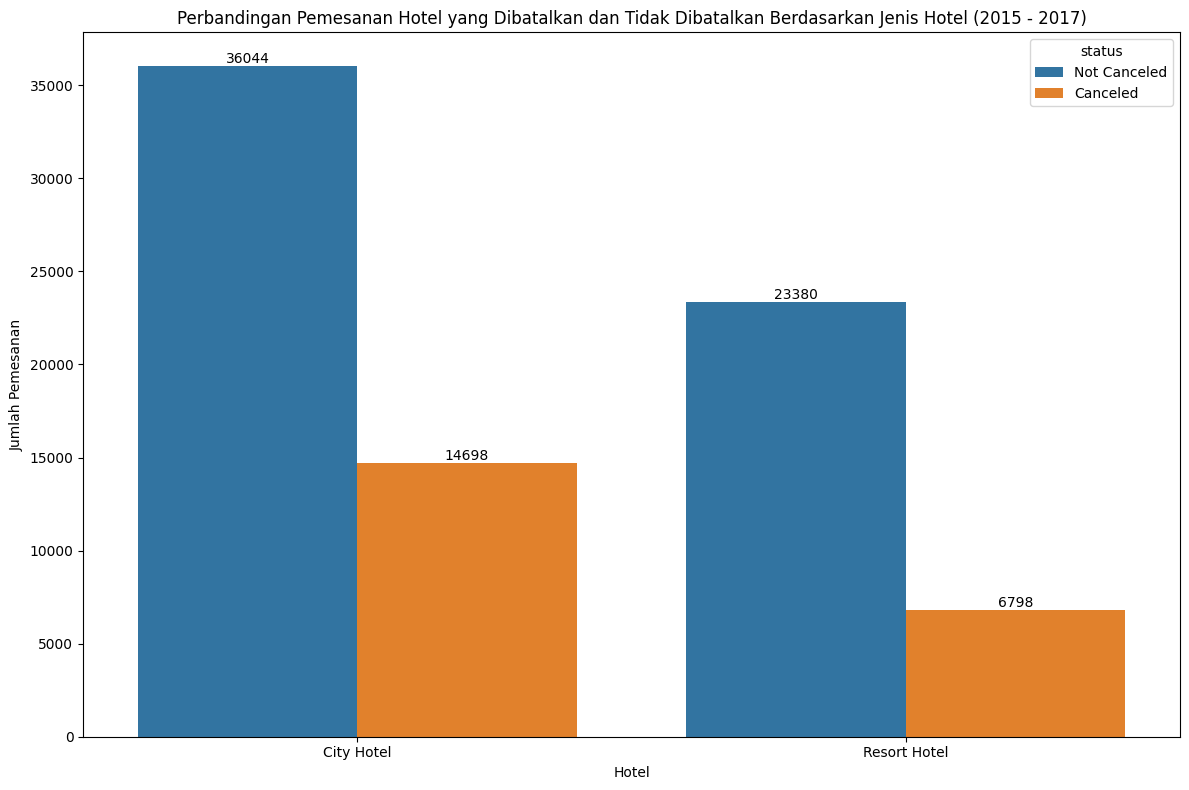

In [76]:
# Melihat jumlah pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan jenis hotel

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['hotel', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_hotel_barplot = sns.barplot(
    data=counts, x='hotel', y='count', hue='status'
  )

for container in cancelation_rate_by_hotel_barplot.containers:
    cancelation_rate_by_hotel_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Jenis Hotel (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Hotel')
plt.tight_layout()
plt.show()

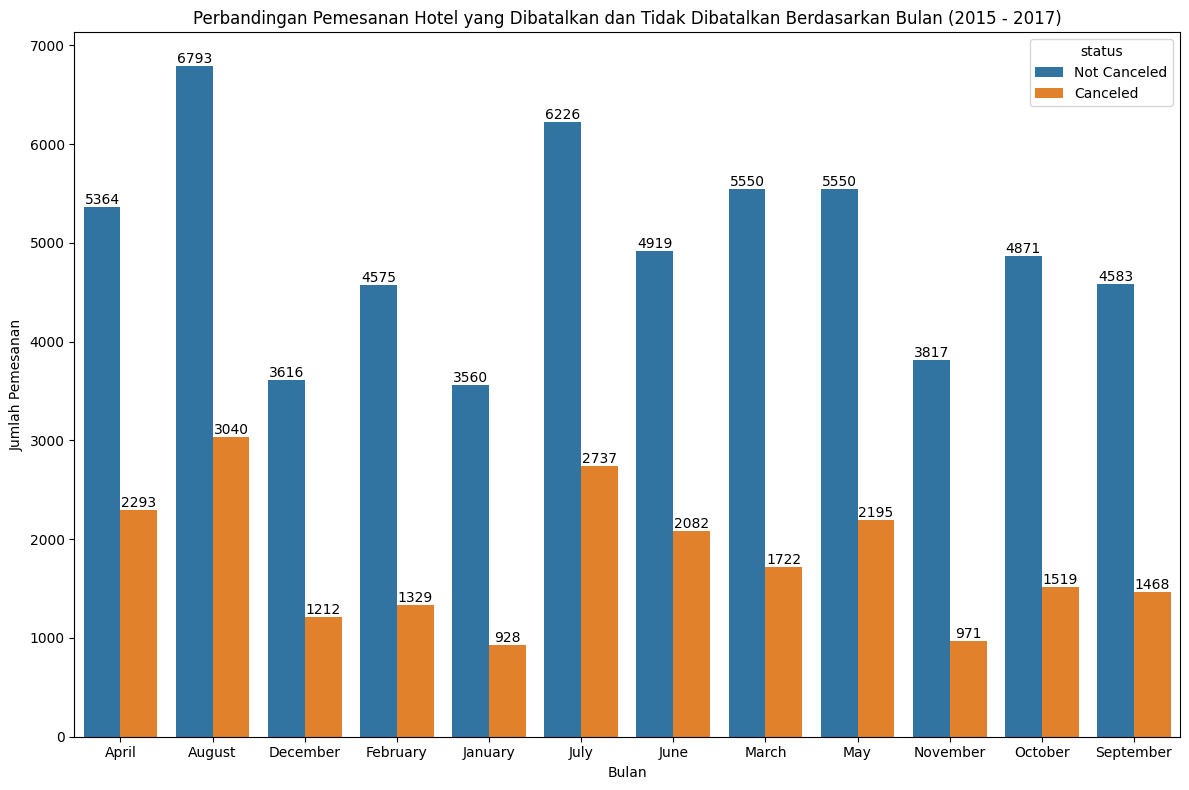

In [77]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan bulan

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['arrival_date_month', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_per_month_barplot = sns.barplot(
    data=counts, x='arrival_date_month', y='count', hue='status'
  )

for container in cancelation_rate_per_month_barplot.containers:
    cancelation_rate_per_month_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Bulan (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

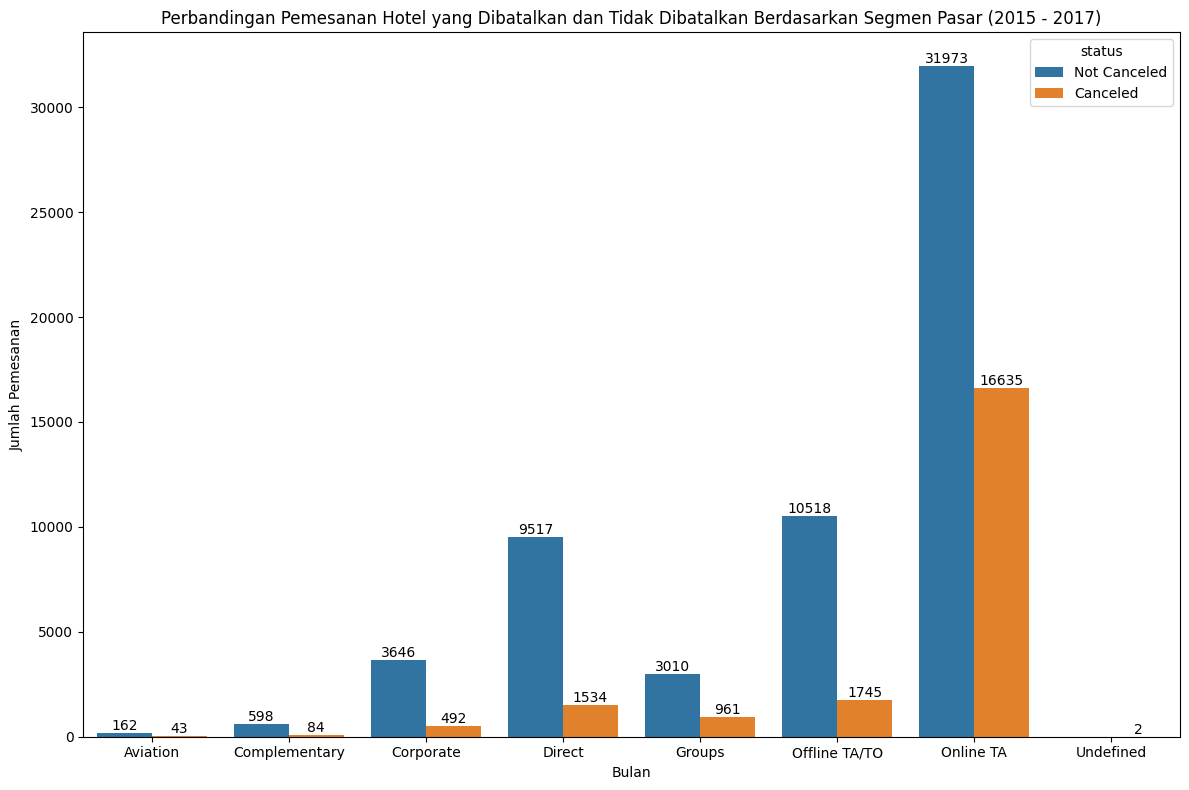

In [78]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan segmen pasar

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['market_segment', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_market_segment_barplot = sns.barplot(
    data=counts, x='market_segment', y='count', hue='status'
  )

for container in cancelation_rate_by_market_segment_barplot.containers:
    cancelation_rate_by_market_segment_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Segmen Pasar (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

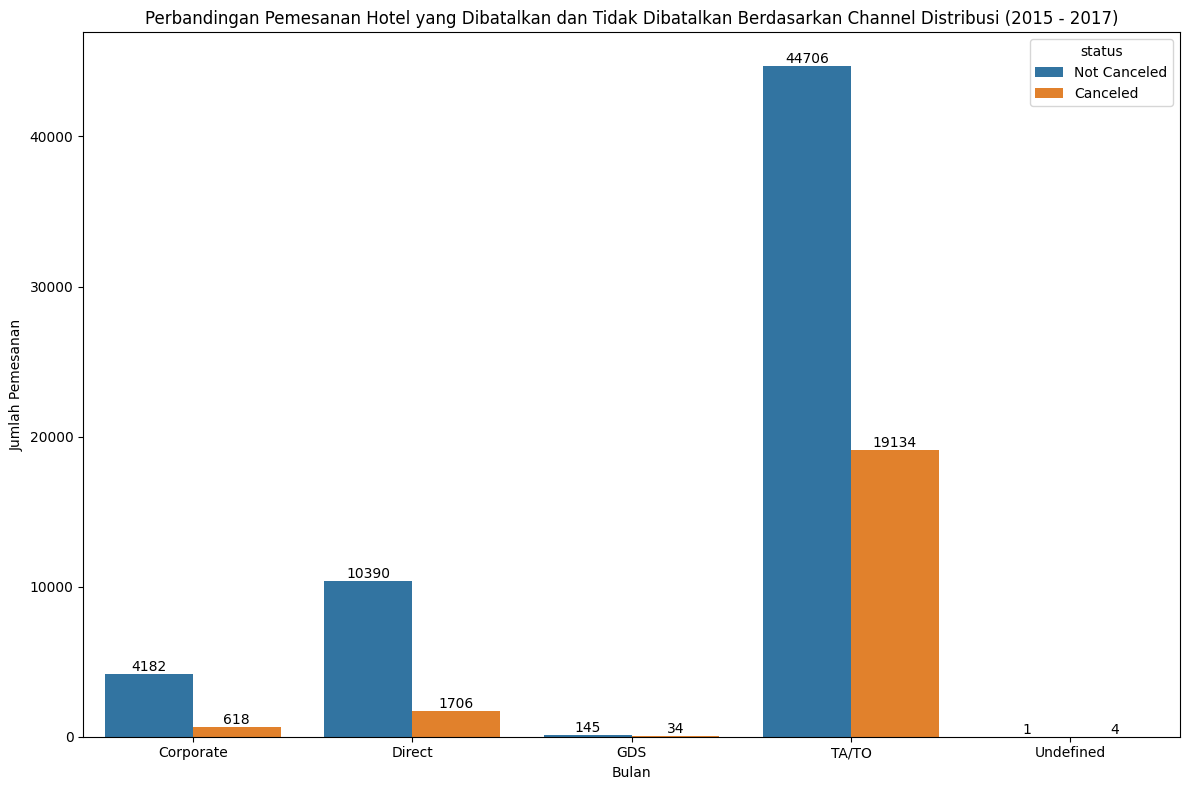

In [79]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan distribution channel

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['distribution_channel', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

counts['status'] = counts['is_canceled'].map({0: 'Not Canceled', 1: 'Canceled'})

cancelation_rate_by_distribution_channel_barplot = sns.barplot(
    data=counts, x='distribution_channel', y='count', hue='status'
  )

for container in cancelation_rate_by_distribution_channel_barplot.containers:
    cancelation_rate_by_distribution_channel_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Channel Distribusi (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

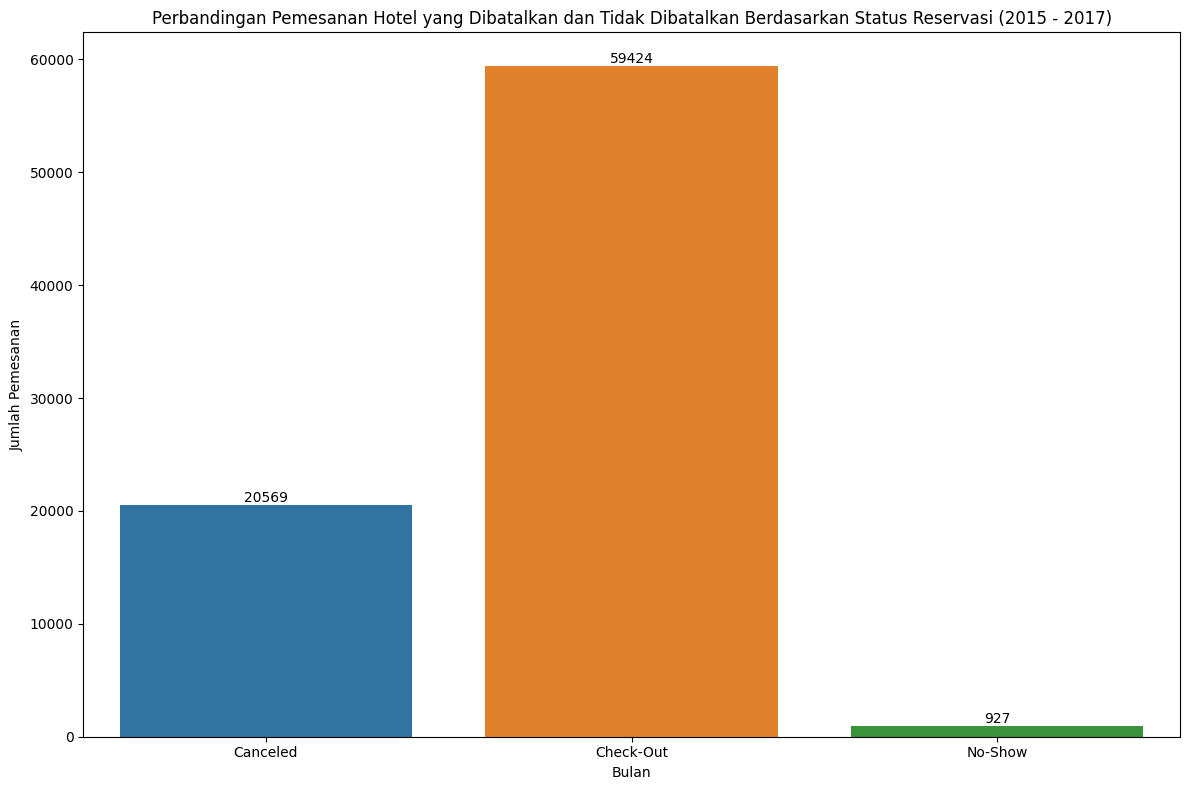

In [80]:
# Melihat perbandingan pemesanan hotel yang dibatalkan dan tidak dibatalkan berdasarkan status reservasi

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby(['reservation_status', 'is_canceled'])
      .size()
      .reset_index(name='count')
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='reservation_status', y='count', hue='reservation_status'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Pemesanan Hotel yang Dibatalkan dan Tidak Dibatalkan Berdasarkan Status Reservasi (2015 - 2017)')
plt.ylabel('Jumlah Pemesanan')
plt.xlabel('Bulan')
plt.tight_layout()
plt.show()

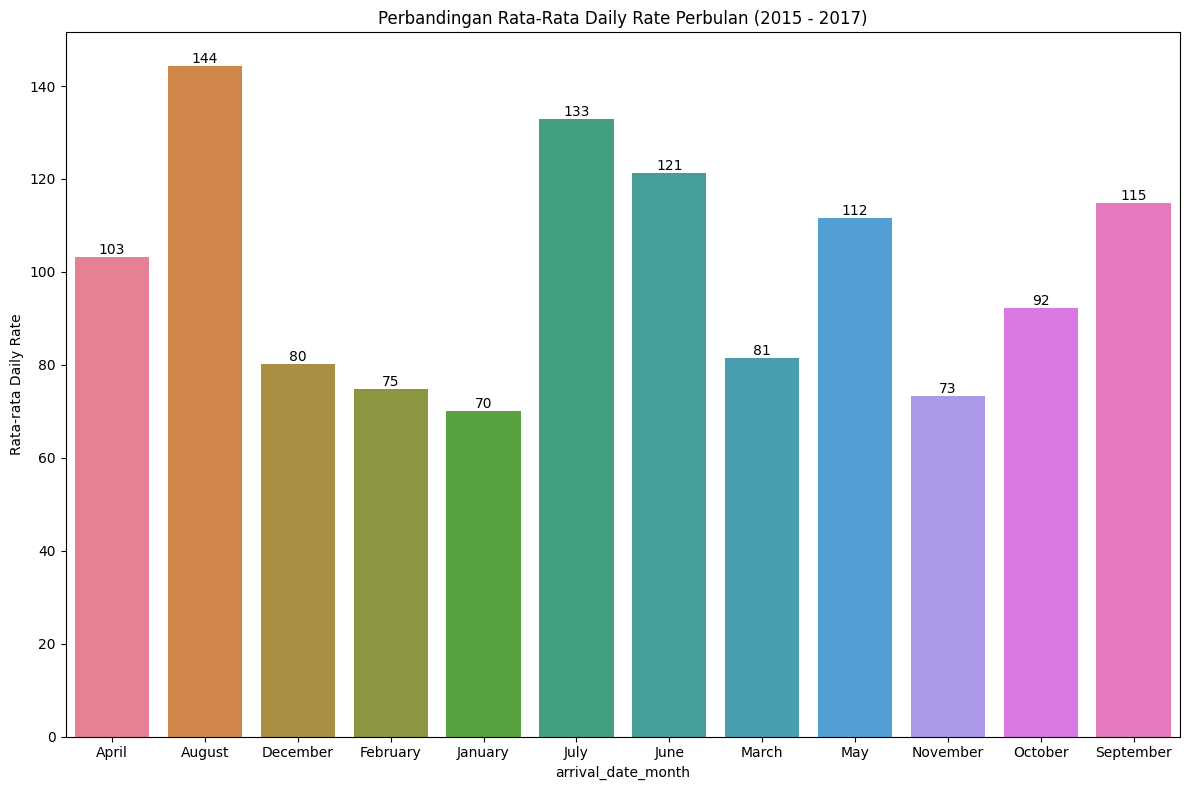

In [81]:
# Melihat perbandingan rata-rata average daily rate perbulan dari 2015-2017

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_month')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_month', y='avg_adr', hue='arrival_date_month'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate Perbulan (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

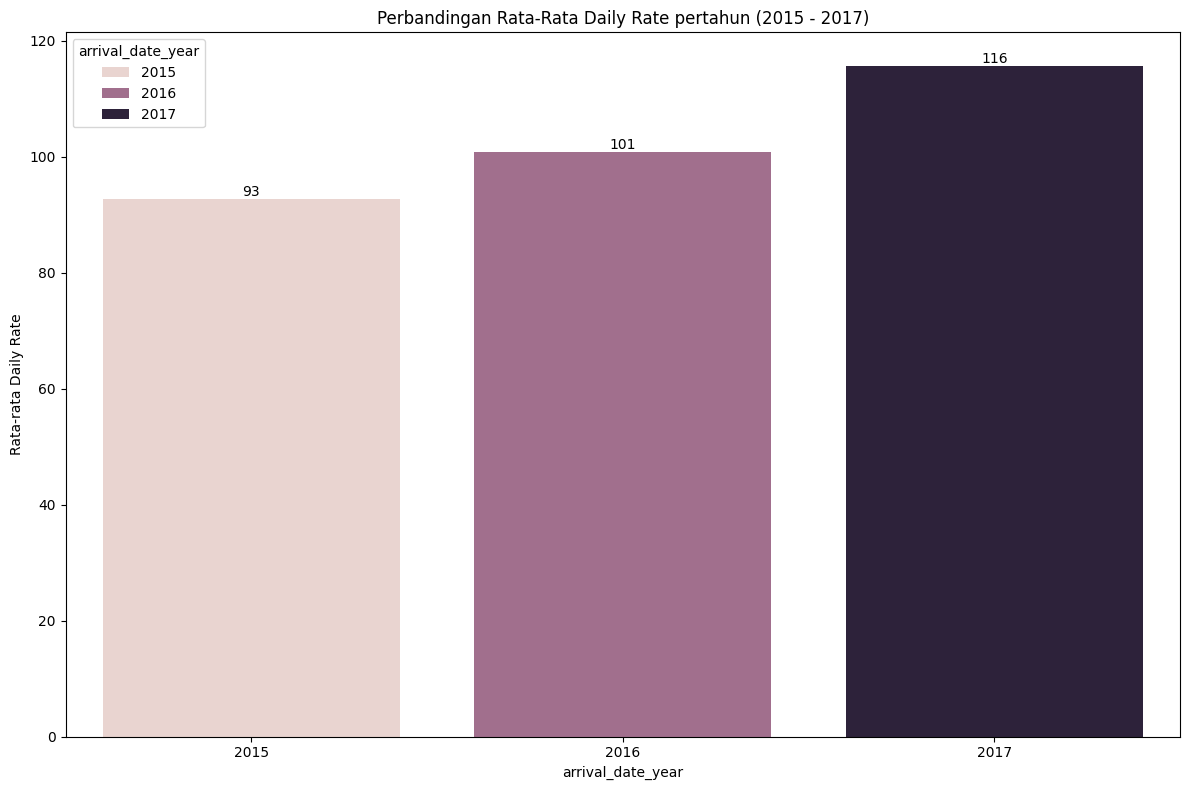

In [82]:
# Melihat perbandingan rata-rata average daily rate pertahun dari 2015-2017

plt.figure(figsize=(12, 8))

counts = (
    df_hotel_demand_bookings.groupby('arrival_date_year')['adr']
      .mean()
      .reset_index()
      .rename(columns={'adr':'avg_adr'})
)

cancelation_rate_by_reservation_status_barplot = sns.barplot(
    data=counts, x='arrival_date_year', y='avg_adr', hue='arrival_date_year'
  )

for container in cancelation_rate_by_reservation_status_barplot.containers:
    cancelation_rate_by_reservation_status_barplot.bar_label(container, fmt='%.0f')

plt.title('Perbandingan Rata-Rata Daily Rate pertahun (2015 - 2017)')
plt.ylabel('Rata-rata Daily Rate')
plt.tight_layout()
plt.show()

MODELLING

In [83]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, OrdinalEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [84]:
new_df = df_hotel_demand_bookings.copy()
new_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,9.800e+01,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,C,0,No Deposit,0,Transient,1.070e+02,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,C,0,No Deposit,0,Transient,1.030e+02,0,1,Check-Out,2015-07-03


In [85]:
print(len(new_df[new_df['is_canceled']==0]))
print(len(new_df[new_df['is_canceled']==1]))


59424
21496


In [86]:
categorical_cols = new_df.select_dtypes(include=['category', 'object']).columns.tolist()
print(categorical_cols)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']


using Imbalance

In [89]:
# Count the frequency of each country
country_counts = new_df['country'].value_counts()

# Create a mask for countries with fewer than 50 occurrences
rare_countries = country_counts[country_counts < 50].index

# Replace rare countries with 'Other'
new_df['country'] = new_df['country'].replace(rare_countries, 'Other')


In [116]:
new_df['country'].unique()

array(['GBR', 'PRT', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'ARG',
       'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'DNK', 'RUS',
       'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'ITA', 'FIN', 'Other', 'LUX',
       'IND', 'CHN', 'MEX', 'MAR', 'SRB', 'CHL', 'AUT', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'DZA', 'KOR', 'HUN', 'HRV', 'IRN', 'unknown',
       'COL', 'NZL', 'UKR', 'JPN', 'BGR'], dtype=object)

In [90]:
new_df['total_stay'] = new_df['stays_in_week_nights'] + new_df['stays_in_weekend_nights']
new_df['total_spending'] = new_df['adr'] * new_df['total_stay']

In [91]:
new_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_stay,total_spending
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02,1,7.500e+01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,0,Transient,7.500e+01,0,0,Check-Out,2015-07-02,1,7.500e+01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,0,Transient,9.800e+01,0,1,Check-Out,2015-07-03,2,1.960e+02
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,0,Transient,1.070e+02,0,0,Check-Out,2015-07-03,2,2.140e+02
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,0,Transient,1.030e+02,0,1,Check-Out,2015-07-03,2,2.060e+02


In [92]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import CondensedNearestNeighbour, NeighbourhoodCleaningRule, NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import category_encoders as cef
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Prepare features and target
X = new_df.drop(['is_canceled', 'reservation_status_date'], axis=1)
y = new_df['is_canceled']
leakage_cols = [
                'arrival_date_week_number', 'arrival_date_day_of_month',
                'days_in_waiting_list',
                'babies', 'deposit_type',
                'reservation_status',
                'arrival_date_year', 
                'deposit_type', 
                'assigned_room_type',
                'hotel', 'meal', 'reserved_room_type',
                'arrival_date_month'
]
X = X.drop(columns=leakage_cols)
categorical_cols = X.select_dtypes(include='object').columns.tolist()
num_cols_names = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# from sklearn.metrics import make_scorer

# def custom_weighted_metric(y_true, y_pred):
#     recall = recall_score(y_true, y_pred, pos_label=1)
#     precision = precision_score(y_true, y_pred, pos_label=1)
#     return 0.7 * recall + 0.3 * precision

# weighted_scorer = make_scorer(custom_weighted_metric)

# Train-test split (safe, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
object_pipeline = Pipeline([('encode', ce.BinaryEncoder())])
numerical_pipeline = Pipeline([('scaling', RobustScaler())])

transformer = ColumnTransformer([
    ('cat_preprocessing', object_pipeline, categorical_cols),
    ('num_preprocessing', numerical_pipeline, num_cols_names)
], remainder='passthrough')

# ImbalanceSampler
sampler =  [
    SMOTEENN(),
    SMOTE(),
    NeighbourhoodCleaningRule(),
    NearMiss() ] 

# Models
models = {
    'KNN': KNeighborsClassifier(),  
    'LogReg': LogisticRegression(random_state=42, max_iter=1000),
    'RF': RandomForestClassifier(random_state=42),
    'DT': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),  
    'GB': GradientBoostingClassifier(random_state=42),  
    'LightGBM': LGBMClassifier(random_state=42) 
}

# Pipeline
pipeline = Pipeline([
    ('preprocess', transformer),
    ('sampler', NearMiss()),
    ('model', LogisticRegression())  # placeholder
], memory=None)

# Grid for models only
param_grid = {
    'model': list(models.values()),
    'sampler' : sampler
}

# Cross-validation
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

# Grid search
search_model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # ← use the custom weighted scorer
    cv=skfold,
    n_jobs=-1,
    error_score='raise'
)

# Fit
search_model.fit(X_train, y_train)

# Predict
y_pred = search_model.predict(X_test)
y_proba = search_model.predict_proba(X_test)[:, 1]

# akurasi = accuracy_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# presisi = precision_score(y_test, y_pred)

# CV Results DataFrame
import pandas as pd
results_df = pd.DataFrame(search_model.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
results_df.head()

# Evaluate
print("Best Params:", search_model.best_params_)
print("Best CV Recall:", search_model.best_score_)
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred))
# print("Accuracy : ", akurasi)
# print("recall : ", recall)
# print("f1 : ", f1)
# print("presisi : ", presisi)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937
Best Params: {'model': LGBMClassifier(random_state=42), 'sampler': NeighbourhoodCleaningRule()}
Best CV Recall: 0.6612866850002901

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86     11885
           1       0.60      0.73      0.66      4299

    accuracy                           0.80     16184
   macro avg       0.75      0.78      0.76     16184
wei

c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [98]:
pipeline = search_model.best_estimator_
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessing',
                                                  Pipeline(steps=[('encode',
                                                                   BinaryEncoder())]),
                                                  ['country', 'market_segment',
                                                   'distribution_channel',
                                                   'customer_type']),
                                                 ('num_preprocessing',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_stay',
                                                   'total_spending'])])),
                ('sampler', NeighbourhoodCleaningRule()),
                ('model', LGBMClassifier(random_state=42))])

HYPERPARAMETER

In [94]:
from imblearn.pipeline import Pipeline  # make sure this is from imblearn, not sklearn
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.combine import SMOTEENN
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define the pipeline with correct order: preprocessing → sampler → model
pipeline = Pipeline([
    ('preprocess', transformer),
    ('sampler', NeighbourhoodCleaningRule()),
    ('Model', LGBMClassifier(random_state=42))  # model must be last
])

# Parameter grid for RandomizedSearchCV
param_grid = {
    'Model__n_estimators': [100, 300, 500, 1000],
    'Model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'Model__max_depth': [-1, 5, 10, 20],
    'Model__num_leaves': [15, 31, 50, 100],
    'Model__min_child_samples': [10, 20, 50, 100],
    'Model__reg_alpha': [0, 0.1, 1, 10],
    'Model__reg_lambda': [0, 0.1, 1, 10],
    'Model__random_state': [42]
}

# Cross-validation
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# Randomized Search
RD_Tuning = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    cv=skfold,
    scoring="f1",
    n_jobs=-1,
    n_iter=20,
    error_score="raise",
    random_state=42
)

# Fit
RD_Tuning.fit(X_train, y_train)

# Results
print("Best recall:", RD_Tuning.best_score_)
print("Best parameters:", RD_Tuning.best_params_)

# Predict
y_pred_tuned = RD_Tuning.predict(X_test)
y_proba_tuned = RD_Tuning.predict_proba(X_test)[:, 1]

# Evaluate
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# CV Results DataFrame
import pandas as pd
results_df = pd.DataFrame(RD_Tuning.cv_results_).sort_values(by='rank_test_score').set_index('rank_test_score')
results_df.head()


[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Model__reg_lambda,param_Model__reg_alpha,param_Model__random_state,param_Model__num_leaves,param_Model__n_estimators,param_Model__min_child_samples,...,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,1.355e+02,7.572e+00,6.108e-02,8.158e-03,1.000e-01,1.000e+00,42,100,300,10,...,6.648e-01,6.615e-01,6.545e-01,6.655e-01,6.635e-01,6.607e-01,6.650e-01,6.513e-01,6.607e-01,4.683e-03
2,4.978e+01,1.725e+01,5.368e-02,1.076e-02,1.000e+00,0.000e+00,42,15,500,10,...,6.687e-01,6.588e-01,6.552e-01,6.673e-01,6.615e-01,6.595e-01,6.637e-01,6.572e-01,6.606e-01,4.386e-03
3,1.667e+02,4.150e+00,5.075e-02,4.917e-03,0.000e+00,1.000e-01,42,100,300,20,...,6.627e-01,6.635e-01,6.559e-01,6.637e-01,6.553e-01,6.629e-01,6.703e-01,6.553e-01,6.603e-01,4.879e-03
4,1.008e+02,3.892e+01,5.249e-02,4.208e-03,1.000e+01,0.000e+00,42,50,300,10,...,6.637e-01,6.580e-01,6.550e-01,6.652e-01,6.630e-01,6.564e-01,6.667e-01,6.589e-01,6.599e-01,4.377e-03
5,6.222e+01,1.950e+01,5.786e-02,1.090e-02,1.000e+00,1.000e-01,42,50,300,10,...,6.675e-01,6.566e-01,6.554e-01,6.628e-01,6.591e-01,6.583e-01,6.653e-01,6.580e-01,6.598e-01,3.987e-03


In [95]:
akurasi = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
presisi = precision_score(y_test, y_pred)

print("Accuracy : ", akurasi)
print("recall : ", recall)
print("f1 : ", f1)
print("presisi : ", presisi)

akurasi = accuracy_score(y_test, y_pred_tuned)
recall = recall_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned)
presisi = precision_score(y_test, y_pred_tuned)
print("\n")
print("Accuracy : ", akurasi)
print("recall : ", recall)
print("f1 : ", f1)
print("presisi : ", presisi)

Accuracy :  0.7976396440929313
recall :  0.7317980925796697
f1 :  0.6576774328420613
presisi :  0.5971905846621108


Accuracy :  0.7947973306969847
recall :  0.7590137241218888
f1 :  0.6627399207880573
presisi :  0.588139870223504


In [96]:
pipeline_tuned = RD_Tuning.best_estimator_
pipeline_tuned.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessing',
                                                  Pipeline(steps=[('encode',
                                                                   BinaryEncoder())]),
                                                  ['country', 'market_segment',
                                                   'distribution_channel',
                                                   'customer_type']),
                                                 ('num_preprocessing',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   '...
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes', 'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_stay',
                                                   'total_spending'])])),
                ('sampler', NeighbourhoodCleaningRule()),
                ('Model',
                 LGBMClassifier(learning_rate=0.05, max_depth=10,
                                min_child_samples=10, n_estimators=300,
                                num_leaves=100, random_state=42, reg_alpha=1,
                                reg_lambda=0.1))])

In [99]:
y_pred = pipeline.predict(X_test)
y_pred_proba =pipeline.predict_proba(X_test)
y_pred_tuned = pipeline_tuned.predict(X_test)
y_pred_proba_tuned = pipeline_tuned.predict_proba(X_test)

c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937


c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 17197, number of negative: 32808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 50005, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343906 -> initscore=-0.645937
[LightGBM] [Info] Start training from score -0.645937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


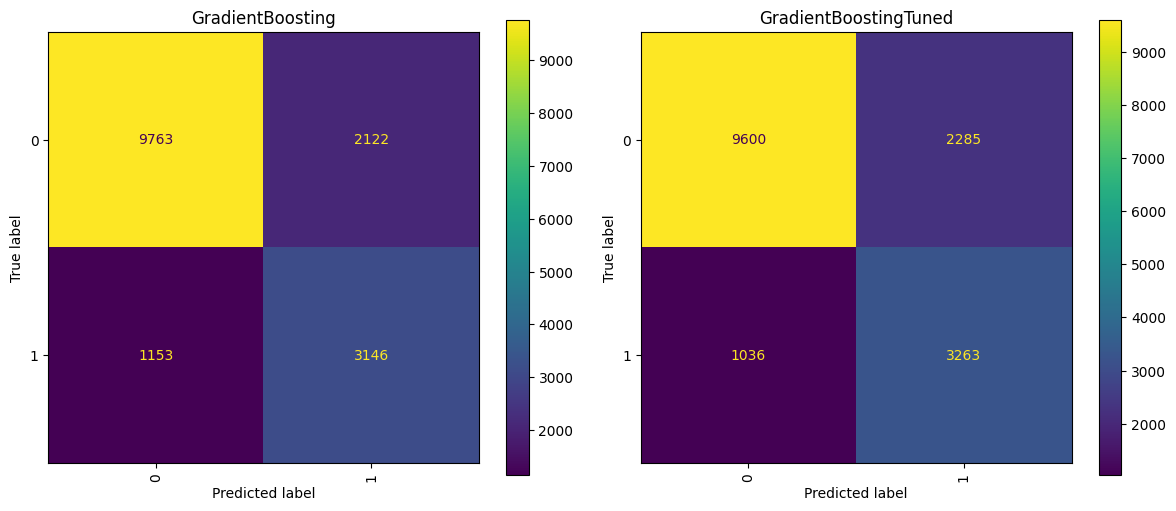

In [100]:
classifiers = {
    "GradientBoosting" : pipeline,
    "GradientBoostingTuned" : pipeline_tuned
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    
    axes[i].set_title(key)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [101]:
class_report = classification_report(y_test, y_pred)
class_report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Test Default: \n', class_report)
print('Classification Report Test Tuned: \n', class_report_tuned)

Classification Report Test Default: 
               precision    recall  f1-score   support

           0       0.90      0.81      0.85     11885
           1       0.59      0.76      0.66      4299

    accuracy                           0.79     16184
   macro avg       0.75      0.78      0.76     16184
weighted avg       0.82      0.79      0.80     16184

Classification Report Test Tuned: 
               precision    recall  f1-score   support

           0       0.90      0.81      0.85     11885
           1       0.59      0.76      0.66      4299

    accuracy                           0.79     16184
   macro avg       0.75      0.78      0.76     16184
weighted avg       0.82      0.79      0.80     16184



In [112]:
prediction_vs_proba = pd.DataFrame(data=[y_pred, y_pred_proba], index=['class', 'proba']).transpose()
prediction_vs_proba

,class,proba
0,1,"[0.3171182568497931, 0.6828817431502069]"
1,1,"[0.1348656457033225, 0.8651343542966775]"
2,0,"[0.6434866074355834, 0.35651339256441666]"
3,0,"[0.8304077129229049, 0.16959228707709506]"
4,1,"[0.04593504186567843, 0.9540649581343216]"
...,...,...
16179,0,"[0.9960540867740482, 0.003945913225951824]"
16180,0,"[0.6495745203873922, 0.3504254796126079]"
16181,0,"[0.8209300855914575, 0.17906991440854245]"
16182,1,"[0.1880889814099207, 0.8119110185900793]"


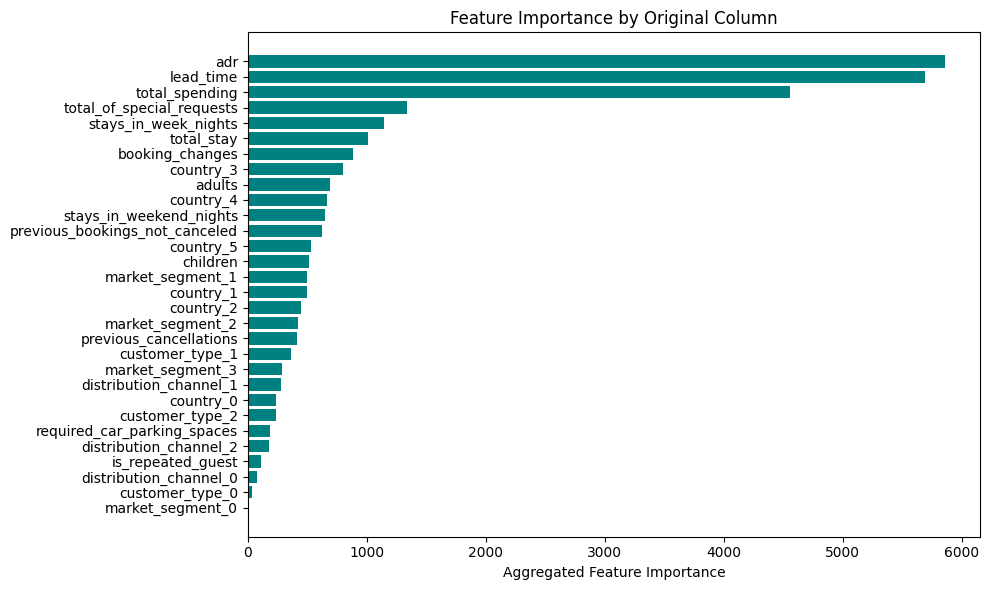

In [113]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 1. Get the best model from grid search
best_model = RD_Tuning.best_estimator_

# 2. Get feature importances (supports tree-based models)
model = best_model.named_steps['Model']

importances = model.feature_importances_

# 3. Get feature names after transformation
# Get categorical and numerical feature names from the transformers
encoder = best_model.named_steps['preprocess'].named_transformers_['cat_preprocessing'].named_steps['encode']
encoded_cat_features = encoder.get_feature_names_out(categorical_cols)

num_features = num_cols_names

# Combine all feature names
feature_names = list(encoded_cat_features) + list(num_features)

# 4. Map encoded feature names back to original column names
encoded_col_map = {}
for original_col, feature_list in zip(categorical_cols, encoder.get_feature_names_out()):
    for f in feature_list:
        encoded_col_map[f] = original_col

# Map and aggregate feature importances
decoded_importance = [(encoded_col_map.get(f, f), imp) for f, imp in zip(feature_names, importances)]

# Aggregate by original feature
agg_importance = defaultdict(float)
for orig, imp in decoded_importance:
    agg_importance[orig] += imp

# Sort by importance
sorted_agg = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)

# 5. Plot
plt.figure(figsize=(10, 6))
labels, values = zip(*sorted_agg)
plt.barh(labels[::-1], values[::-1], color='teal')
plt.xlabel('Aggregated Feature Importance')
plt.title('Feature Importance by Original Column')
plt.tight_layout()
plt.show()


100%|===================| 16136/16184 [03:33<00:00]        

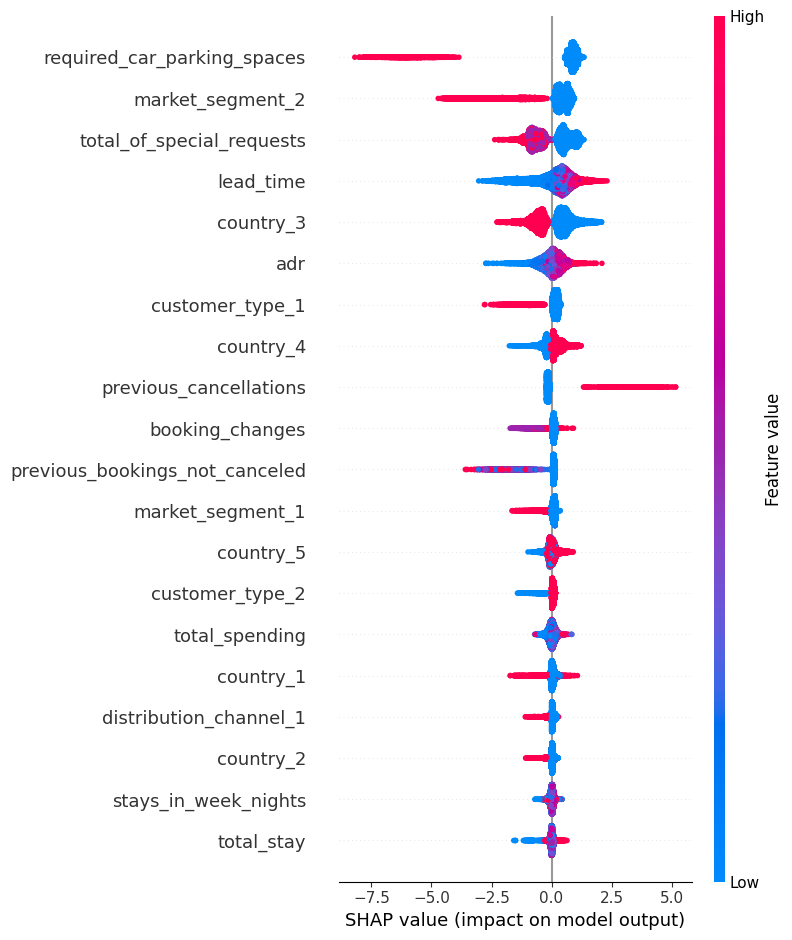

In [104]:
import shap

# 1. Get the best pipeline components
best_model = RD_Tuning.best_estimator_
preprocessor = best_model.named_steps['preprocess']
model = best_model.named_steps['Model']

# 2. Transform the test set (skip the sampler)
X_test_transformed = preprocessor.transform(X_test)

# 3. Get correct feature names
encoder = preprocessor.named_transformers_['cat_preprocessing'].named_steps['encode']
cat_encoded_names = encoder.get_feature_names_out(categorical_cols)
feature_names = list(cat_encoded_names) + num_cols_names  # final column names

# 4. Create SHAP explainer on raw model + transformed data
explainer = shap.Explainer(model, X_test_transformed)

# 5. Compute SHAP values
shap_values = explainer(X_test_transformed,check_additivity=False)

# 6. Plot
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)

In [105]:
# For one instance (e.g. index 0)
# shap.plots.waterfall(shap_values[1], max_display=10)

c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Legion\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


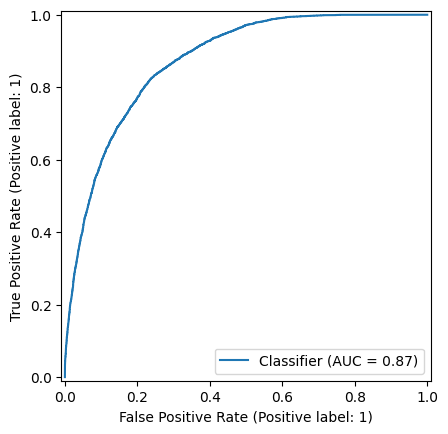

In [106]:
from sklearn.metrics import RocCurveDisplay

y_pred = pipeline_tuned.predict(X_test)
y_pred_proba =pipeline_tuned.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
auc_display =  RocCurveDisplay.from_predictions(y_test, y_pred_proba[:,1]).roc_auc


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Step 1: Create ADR bins
adr_bins = [0, 50, 80, 110, 150, 200, new_df['adr'].max()]
labels = ['0-50', '51-80', '81-110', '111-150', '151-200', '200+']
new_df['adr_bin'] = pd.cut(new_df['adr'], bins=adr_bins, labels=labels, include_lowest=True)

# Step 2: Get overall not-canceled rate
overall_prop_not_canceled = (new_df['is_canceled'] == 0).mean()

# Step 3: Initialize list to store results
results = []

# Step 4: Analyze each bin
for label in labels:
    bin_new_df = new_df[new_df['adr_bin'] == label]
    if bin_new_df.empty:
        continue  # skip empty bins

    total = len(bin_new_df)
    not_canceled = (bin_new_df['is_canceled'] == 0).sum()
    canceled = total - not_canceled
    prop_not_canceled = not_canceled / total

    # Chi-squared test comparing this bin vs. all others
    others = new_df[new_df['adr_bin'] != label]
    not_canceled_others = (others['is_canceled'] == 0).sum()
    canceled_others = (others['is_canceled'] == 1).sum()

    table = np.array([
        [not_canceled, canceled],
        [not_canceled_others, canceled_others]
    ])

    chi2, p, _, _ = chi2_contingency(table)

    # Save results
    results.append({
        'ADR Bin': label,
        'Total': total,
        'Prop Not Canceled': round(prop_not_canceled, 3),
        'Diff from Overall': round(prop_not_canceled - overall_prop_not_canceled, 3),
        'p-value': round(p, 4)
    })

# Step 5: Print result as DataFrame
result_new_df = pd.DataFrame(results)
print(result_new_df.sort_values(by='ADR Bin'))


   ADR Bin  Total  Prop Not Canceled  Diff from Overall   p-value
0     0-50   9141          8.550e-01          1.210e-01 0.000e+00
3  111-150  18921          6.770e-01         -5.700e-02 0.000e+00
4  151-200   9961          6.700e-01         -6.500e-02 0.000e+00
5     200+   3511          6.290e-01         -1.050e-01 0.000e+00
1    51-80  17501          7.910e-01          5.700e-02 0.000e+00
2   81-110  21884          7.340e-01         -1.000e-03 8.420e-01


In [144]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Step 1: Create ADR bins
adr_bins = [0, 50, 80, 110, 150, 200, new_df['adr'].max()]
labels = ['0-50', '51-80', '81-110', '111-150', '151-200', '200+']
new_df['adr_bin'] = pd.cut(new_df['adr'], bins=adr_bins, labels=labels, include_lowest=True)

# Step 2: Get overall not-canceled rate
overall_prop_not_canceled = (new_df['is_canceled'] == 1).mean()

# Step 3: Initialize list to store results
results = []

# Step 4: Analyze each bin
for label in labels:
    bin_new_df = new_df[new_df['adr_bin'] == label]
    if bin_new_df.empty:
        continue  # skip empty bins

    total = len(bin_new_df)
    not_canceled = (bin_new_df['is_canceled'] == 1).sum()
    canceled = total - not_canceled
    prop_not_canceled = not_canceled / total

    # Chi-squared test comparing this bin vs. all others
    others = new_df[new_df['adr_bin'] != label]
    not_canceled_others = (others['is_canceled'] == 1).sum()
    canceled_others = (others['is_canceled'] == 0).sum()

    table = np.array([
        [not_canceled, canceled],
        [not_canceled_others, canceled_others]
    ])

    chi2, p, _, _ = chi2_contingency(table)

    # Save results
    results.append({
        'ADR Bin': label,
        'Total': total,
        'Prop Not Canceled': round(prop_not_canceled, 3),
        'Diff from Overall': round(prop_not_canceled - overall_prop_not_canceled, 3),
        'p-value': round(p, 4)
    })

# Step 5: Print result as DataFrame
result_new_df = pd.DataFrame(results)
print(result_new_df.sort_values(by='ADR Bin'))


   ADR Bin  Total  Prop Not Canceled  Diff from Overall   p-value
0     0-50   9141          1.450e-01         -1.210e-01 0.000e+00
3  111-150  18921          3.230e-01          5.700e-02 0.000e+00
4  151-200   9961          3.300e-01          6.500e-02 0.000e+00
5     200+   3511          3.710e-01          1.050e-01 0.000e+00
1    51-80  17501          2.090e-01         -5.700e-02 0.000e+00
2   81-110  21884          2.660e-01          1.000e-03 8.420e-01


In [143]:
import pandas as pd
from scipy.stats import binomtest

# Example binning
bins = [0, 50, 80, 110, 150, 200, new_df['adr'].max()]
labels = ['0-50', '51-80', '81-110', '111-150', '151-200', '200+']
new_df['adr_bin'] = pd.cut(new_df['adr'], bins=bins, labels=labels, include_lowest=True)

# Overall proportion of cancellations
overall_canceled_prop = (new_df['is_canceled'] == 1).mean()

result = []

for bin_label in labels:
    subset = new_df[new_df['adr_bin'] == bin_label]
    n = len(subset)
    canceled = (subset['is_canceled'] == 1).sum()
    prop_canceled = canceled / n
    diff = prop_canceled - overall_canceled_prop
    
    # Binomial test
    p_val = binomtest(canceled, n, overall_canceled_prop).pvalue

    result.append({
        'ADR Bin': bin_label,
        'Total': n,
        'Prop Canceled': prop_canceled,
        'Diff from Overall': diff,
        'p-value': p_val
    })

new_df_result = pd.DataFrame(result)
print(new_df_result.sort_values('Prop Canceled', ascending=False))


   ADR Bin  Total  Prop Canceled  Diff from Overall    p-value
5     200+   3511      3.705e-01          1.049e-01  4.244e-42
4  151-200   9961      3.305e-01          6.484e-02  1.632e-46
3  111-150  18921      3.226e-01          5.691e-02  1.670e-67
2   81-110  21884      2.662e-01          5.311e-04  8.603e-01
1    51-80  17501      2.087e-01         -5.697e-02  1.546e-68
0     0-50   9141      1.447e-01         -1.209e-01 1.088e-170


In [146]:
# Define lead time bins
bins = [0, 30, 60, 90, 120, 150, 180, 9999]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150', '151-180', '180+']
new_df['lead_time_bin'] = pd.cut(new_df['lead_time'], bins=bins, labels=labels, include_lowest=True)

# Overall cancellation proportion
overall_cancel_rate = new_df['is_canceled'].mean()

# Group by bins and calculate proportions and p-values
summary = new_df.groupby('lead_time_bin')['is_canceled'].agg(['count', 'sum']).reset_index()
summary.columns = ['Lead Time Bin', 'Total', 'Canceled']
summary['Prop Canceled'] = summary['Canceled'] / summary['Total']
summary['Diff from Overall'] = summary['Prop Canceled'] - overall_cancel_rate

# Binomial test for each bin
summary['p-value'] = summary.apply(
    lambda row: binomtest(int(row['Canceled']), int(row['Total']), overall_cancel_rate).pvalue,
    axis=1
)

summary.sort_values('Lead Time Bin', inplace=True)
summary.reset_index(drop=True, inplace=True)
summary.style.format({
    'Prop Canceled': '{:.3f}',
    'Diff from Overall': '{:+.3f}',
    'p-value': '{:.3e}'
})

C:\Users\Legion\AppData\Local\Temp\ipykernel_20620\1939159793.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = new_df.groupby('lead_time_bin')['is_canceled'].agg(['count', 'sum']).reset_index()


,Lead Time Bin,Total,Canceled,Prop Canceled,Diff from Overall,p-value
0,0-30,33751,5421,0.161,-0.105,0.000e+00
1,31-60,12903,4064,0.315,+0.049,1.357e-35
2,61-90,9031,2923,0.324,+0.058,2.481e-34
3,91-120,6954,2420,0.348,+0.082,1.256e-51
4,121-150,5428,1922,0.354,+0.088,1.826e-46
5,151-180,4941,1736,0.351,+0.086,5.385e-40
6,180+,7912,3010,0.380,+0.115,9.209e-110


In [149]:
# Define bins and labels
bins = [0, 100, 300, 500, 750, 1000, 1500, np.inf]
labels = ['0-100', '101-300', '301-500', '501-750', '751-1000', '1001-1500', '1500+']
new_df['spending_bin'] = pd.cut(new_df['total_spending'], bins=bins, labels=labels, right=False)

# Overall cancellation rate
overall_cancel_rate = new_df['is_canceled'].mean()

# Calculate stats per bin
results = []
for label in labels:
    subset = new_df[new_df['spending_bin'] == label]
    total = len(subset)
    canceled = subset['is_canceled'].sum()
    prop_canceled = canceled / total if total > 0 else 0
    diff_from_overall = prop_canceled - overall_cancel_rate
    p_value = binomtest(canceled, total, overall_cancel_rate).pvalue if total > 0 else np.nan

    results.append({
        'Spending Bin': label,
        'Total': total,
        'Canceled': canceled,
        'Prop Canceled': round(prop_canceled, 3),
        'Diff from Overall': round(diff_from_overall, 3),
        'p-value': p_value
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df['Spending Bin'] = pd.Categorical(results_df['Spending Bin'], categories=labels, ordered=True)
results_df = results_df.sort_values('Spending Bin')

# Display result
print(results_df.to_string(index=False))

Spending Bin  Total  Canceled  Prop Canceled  Diff from Overall    p-value
       0-100  12769      1816      1.420e-01         -1.230e-01 2.127e-248
     101-300  29492      7128      2.420e-01         -2.400e-02  5.314e-21
     301-500  20318      6100      3.000e-01          3.500e-02  3.271e-28
     501-750  10686      3499      3.270e-01          6.200e-02  2.085e-45
    751-1000   4125      1530      3.710e-01          1.050e-01  2.033e-49
   1001-1500   2853      1140      4.000e-01          1.340e-01  2.601e-54
       1500+    676       283      4.190e-01          1.530e-01  9.143e-18


In [114]:
preprocessor = best_model.named_steps['preprocess']
X_transformed = preprocessor.transform(X_test)
# Get encoded categorical feature names
encoder = preprocessor.named_transformers_['cat_preprocessing'].named_steps['encode']
encoded_cat_features = encoder.get_feature_names_out(input_features=categorical_cols)

# Get numerical column names
num_features = num_cols_names

# Combine all
all_feature_names = list(encoded_cat_features) + num_features
import pandas as pd

X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)
X_transformed_df['target'] = y_test.reset_index(drop=True)
X_transformed_df.head()

,country_0,country_1,country_2,country_3,country_4,country_5,market_segment_0,market_segment_1,market_segment_2,market_segment_3,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,total_stay,total_spending,target
0,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,...,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-6.607e-02,0.000e+00,-1.000e+00,-1.000e+00,-5.940e-01,1
1,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00,0.000e+00,1.000e+00,0.000e+00,1.000e+00,...,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-5.938e-01,0.000e+00,-1.000e+00,-5.000e-01,-5.031e-01,0
2,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,...,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-1.338e-01,0.000e+00,0.000e+00,1.000e+00,5.000e-01,0
3,1.000e+00,1.000e+00,0.000e+00,0.000e+00,1.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,...,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-6.917e-01,0.000e+00,0.000e+00,0.000e+00,-3.681e-01,0
4,0.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,1.000e+00,0.000e+00,0.000e+00,0.000e+00,1.000e+00,...,0.000e+00,0.000e+00,0.000e+00,0.000e+00,9.788e-03,0.000e+00,-1.000e+00,0.000e+00,2.761e-02,1


In [119]:
new_df.to_csv('hotel_booking_demands_final.csv', index = False)